# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown
from ast import literal_eval
from sklearn.preprocessing import (
    MultiLabelBinarizer,
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV
)
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    make_scorer,
)
from scipy.stats.mstats import winsorize
from sklearn.linear_model import LinearRegression,Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR,NuSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import pickle
import multiprocessing
import copy
from scipy.stats import kurtosis, skew, iqr, boxcox
import plotly
import plotly.express as px
import plotly.graph_objects as go
import statsmodels
from tqdm import tqdm
import csv
SEED = 43
N_JOBS=max(1,multiprocessing.cpu_count()-1)
sns.set_theme(style='whitegrid', color_codes=True)

def bold(string):
    display(Markdown(string))

# Dataset

In [2]:
dataset=pd.read_csv('./Carbon Emission.csv')
display(dataset.columns)

Index(['Body Type', 'Sex', 'Diet', 'How Often Shower', 'Heating Energy Source',
       'Transport', 'Vehicle Type', 'Social Activity', 'Monthly Grocery Bill',
       'Frequency of Traveling by Air', 'Vehicle Monthly Distance Km',
       'Waste Bag Size', 'Waste Bag Weekly Count', 'How Long TV PC Daily Hour',
       'How Many New Clothes Monthly', 'How Long Internet Daily Hour',
       'Energy efficiency', 'Recycling', 'Cooking_With', 'CarbonEmission'],
      dtype='object')

- Body Type: Građa osobe
- Sex: Pol osobe
- Diet: Tip ishrane
- How Often Shower: Frekvencija tuširanja
- Heating Energy Source: Način grejanja
- Transport: Sredstvo za kretanje
- Vechicle Type: Tip goriva koje koristi sredstvo za kretanje
- Social Activity: Frekvencija socijalnih aktivnosti
- Monthly Grocery Bill: Prosečna mesečna količina potrošenog novca na namirnice
- Frequency of Traveling by Air: Frekvencija upotrebe aviona u prethodnom mesecu
- Vehicle Monthly Distance Km: Broj kilometara pređenih vozilom u toku prethodnog meseca
- Waste Bag Size: Veličina korišćene kese za smeće 
- Waste Bag Weekly Count: Broj izbačenih kesa za smeće nedeljeno
- How Long TV PC Daily Hour: Broj sata koliko je dnevno uključen TV/PC
- How Many New Clothes Monthly: Broj novih artikla odeće kupljenih mesečno
- How Long Internet Daily Hour: Broj sata provedenih na internetu dnevno
- Energy efficiency: Koliko često osoba obraća pažnju na kupovinu energetski efikasnih proizvoda
- Recycling: Tip smeća koja osoba reciklira
- Cooking_With: Uređaji koje osoba koristi za pripremu obroka
- CarbonEmission: Emitovani ugljen dioksid osobe

In [3]:
display(dataset.head(5))

Body Type     Sex         Diet How Often Shower Heating Energy Source  \
0  overweight  female  pescatarian            daily                  coal   
1       obese  female   vegetarian  less frequently           natural gas   
2  overweight    male     omnivore  more frequently                  wood   
3  overweight    male     omnivore      twice a day                  wood   
4       obese  female   vegetarian            daily                  coal   

      Transport Vehicle Type Social Activity  Monthly Grocery Bill  \
0        public          NaN           often                   230   
1  walk/bicycle          NaN           often                   114   
2       private       petrol           never                   138   
3  walk/bicycle          NaN       sometimes                   157   
4       private       diesel           often                   266   

  Frequency of Traveling by Air  Vehicle Monthly Distance Km Waste Bag Size  \
0                    frequently                          210          large   
1                        rarely                            9    extra large   
2                         never                         2472          small   
3                        rarely                           74         medium   
4               very frequently                         8457          large   

   Waste Bag Weekly Count  How Long TV PC Daily Hour  \
0                       4                          7   
1                       3                          9   
2                       1                         14   
3                       3                         20   
4                       1                          3   

   How Many New Clothes Monthly  How Long Internet Daily Hour  \
0                            26                             1   
1                            38                             5   
2                            47                             6   
3                             5                             7   
4                             5                             6   

  Energy efficiency                               Recycling  \
0                No                               ['Metal']   
1                No                               ['Metal']   
2         Sometimes                               ['Metal']   
3         Sometimes  ['Paper', 'Plastic', 'Glass', 'Metal']   
4               Yes                               ['Paper']   

                         Cooking_With  CarbonEmission  
0                   ['Stove', 'Oven']            2238  
1              ['Stove', 'Microwave']            1892  
2               ['Oven', 'Microwave']            2595  
3  ['Microwave', 'Grill', 'Airfryer']            1074  
4                            ['Oven']            4743

In [4]:
bold('**Broj podataka:**')
display(dataset.shape)

**Broj podataka:**

(10000, 20)

In [5]:
display(dataset.dtypes)
display(dataset.dtypes.value_counts())

Body Type                        object
Sex                              object
Diet                             object
How Often Shower                 object
Heating Energy Source            object
Transport                        object
Vehicle Type                     object
Social Activity                  object
Monthly Grocery Bill              int64
Frequency of Traveling by Air    object
Vehicle Monthly Distance Km       int64
Waste Bag Size                   object
Waste Bag Weekly Count            int64
How Long TV PC Daily Hour         int64
How Many New Clothes Monthly      int64
How Long Internet Daily Hour      int64
Energy efficiency                object
Recycling                        object
Cooking_With                     object
CarbonEmission                    int64
dtype: object

object    13
int64      7
Name: count, dtype: int64

In [6]:
def column_values(dataset:pd.DataFrame):
    for col in dataset.columns:
        temp=pd.unique(dataset[col])
        if dataset[col].dtype==object:
            print(f'Column: {col}, has {len(temp)} unique values. {temp}')
        else:
            print(f'Column: {col}, has {len(temp)} unique values, {temp.min()}-{temp.max()}')
display(column_values(dataset))

Column: Body Type, has 4 unique values. ['overweight' 'obese' 'underweight' 'normal']
Column: Sex, has 2 unique values. ['female' 'male']
Column: Diet, has 4 unique values. ['pescatarian' 'vegetarian' 'omnivore' 'vegan']
Column: How Often Shower, has 4 unique values. ['daily' 'less frequently' 'more frequently' 'twice a day']
Column: Heating Energy Source, has 4 unique values. ['coal' 'natural gas' 'wood' 'electricity']
Column: Transport, has 3 unique values. ['public' 'walk/bicycle' 'private']
Column: Vehicle Type, has 6 unique values. [nan 'petrol' 'diesel' 'hybrid' 'lpg' 'electric']
Column: Social Activity, has 3 unique values. ['often' 'never' 'sometimes']
Column: Monthly Grocery Bill, has 250 unique values, 50-299
Column: Frequency of Traveling by Air, has 4 unique values. ['frequently' 'rarely' 'never' 'very frequently']
Column: Vehicle Monthly Distance Km, has 4003 unique values, 0-9999
Column: Waste Bag Size, has 4 unique values. ['large' 'extra large' 'small' 'medium']
Column:

None

Samo kolona "Vehicle Type" ima nan vrednosti, međutim u ovom slučaju nan vrednost znači da osoba ne koristi vozila koja zahtevaju upotrebu goriva te samim tim nije poželjno izbaciti ili modifikovati ovu vrednost. Već ce ona prilikom enkodiranja biti predstavljena kao 0 u svakoj od kolona za tip goriva.  

In [7]:
display(dataset[dataset.duplicated()])

Empty DataFrame
Columns: [Body Type, Sex, Diet, How Often Shower, Heating Energy Source, Transport, Vehicle Type, Social Activity, Monthly Grocery Bill, Frequency of Traveling by Air, Vehicle Monthly Distance Km, Waste Bag Size, Waste Bag Weekly Count, How Long TV PC Daily Hour, How Many New Clothes Monthly, How Long Internet Daily Hour, Energy efficiency, Recycling, Cooking_With, CarbonEmission]
Index: []

# Histogrami dataset-a:

In [8]:
def draw_histograms(dataset,fsize=(40,200),color='darkred'):
    num_cols=2
    num_rows=(dataset.shape[1]+1)//2
    fig,axes=plt.subplots(nrows=num_rows, ncols=num_cols, figsize=fsize)
    for ax,column in zip(axes.flatten(), dataset.columns):
        if(dataset[column].dtype==object):
            sns.histplot(dataset[column], ax=ax, color=color)
            counts = dataset[column].value_counts().sort_index()
            bars = ax.patches
            for bar, label in zip(bars, counts.index):
                height = bar.get_height()
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height / 2,
                    label,
                    ha='center', va='center',
                    fontsize=20, color='white', weight='bold',
                    rotation=90
                )
            ax.set_xticks([])
 
        else:
            sns.histplot(dataset[column], ax=ax, color=color, kde=False)
 
        ax.set_title(column, fontsize=43)
        ax.tick_params(axis='both', which='major', labelsize=35)
        ax.tick_params(axis='both', which='minor', labelsize=35)
        ax.set_xlabel('')
    fig.tight_layout(rect=[0,0.03,1.0,0.7], h_pad=10)
draw_histograms(dataset,color='#6699ff')

# Enkodiranje

### Label enkodiranje

Kolone nad kojima treba primeniti label enkodiranje su:
- Body Type
- How Often Shower
- Social Activity
- Frequency of Traveling by Air
- Waste Bag Size
- Energy efficiency

In [9]:
pd.set_option('future.no_silent_downcasting', True)
#Body Type encoding:
dataset_encoded=dataset.copy(deep=True)
body_weight_mapper = {"underweight": 1, "normal": 2, "overweight": 3, "obese": 4}
dataset_encoded["Body Type"] = dataset_encoded["Body Type"].replace(body_weight_mapper).astype(int)

#How Often Shower encoding: 
shower_mapper = {
        "less frequently": 1,
        "daily": 2,
        "twice a day": 3,
        "more frequently": 4,
    }
dataset_encoded["How Often Shower"] = dataset_encoded["How Often Shower"].replace(shower_mapper).astype(int)

#Social Activity encoding:
social_activity_mapper = {"never": 1, "sometimes": 2, "often": 3}
dataset_encoded["Social Activity"] = dataset_encoded["Social Activity"].replace(
        social_activity_mapper
    ).astype(int)

#Frequency of Traveling by Air encoding:
flights_mapper = {"never": 1, "rarely": 2, "frequently": 3, "very frequently": 4}
dataset_encoded["Frequency of Traveling by Air"] = dataset_encoded["Frequency of Traveling by Air"].replace(flights_mapper).astype(int)

#Waste Bag Size encoding:
waste_bag_mapper = {"small": 1, "medium": 2, "large": 3, "extra large": 4}
dataset_encoded["Waste Bag Size"] = dataset_encoded["Waste Bag Size"].replace(waste_bag_mapper).astype(int)

#Energy efficiency encoding:
energy_efficiency_mapper = {"No": 1, "Sometimes": 2, "Yes": 3}
dataset_encoded["Energy efficiency"] = dataset_encoded["Energy efficiency"].replace(
        energy_efficiency_mapper
    ).astype(int)

display(dataset_encoded.dtypes.value_counts())

int64     13
object     7
Name: count, dtype: int64

 ### One-hot enkodiranje:

 Kolone nad kojima se vrši one-hot enkodiranje:
- Sex
- Diet
- Heating Energy Source
- Transport
- Vehicle Type

In [10]:
# Sex encoding:
dataset_encoded = pd.concat([dataset_encoded, pd.get_dummies(dataset_encoded["Sex"], dtype=int)], axis=1)
dataset_encoded = dataset_encoded.drop("Sex", axis=1)

#Diet encoding:
dataset_encoded = pd.concat([dataset_encoded, pd.get_dummies(dataset_encoded["Diet"], dtype=int)], axis=1)
dataset_encoded = dataset_encoded.drop("Diet", axis=1)

#Heating Enery Source encoding:
dataset_encoded = pd.concat(
        [dataset_encoded, pd.get_dummies(dataset_encoded["Heating Energy Source"], dtype=int)], axis=1
    )
dataset_encoded = dataset_encoded.drop("Heating Energy Source", axis=1)

#Transport encoding:
dataset_encoded = pd.concat(
        [dataset_encoded, pd.get_dummies(dataset_encoded["Transport"], dtype=int)], axis=1
    )
dataset_encoded = dataset_encoded.drop("Transport", axis=1)

#Vehicle Type encoding:
dataset_encoded = pd.concat(
        [dataset_encoded, pd.get_dummies(dataset_encoded["Vehicle Type"], dtype=int)], axis=1
    )
dataset_encoded = dataset_encoded.drop("Vehicle Type", axis=1)

display(dataset_encoded.dtypes.value_counts())

int64     31
object     2
Name: count, dtype: int64

### Multi-hot enkodiranje

Kolone nad kojima se vrši multi-hot enkodiranje:
- Recycling
- Cooking_With

In [11]:
#Recycling encoding:
dataset_encoded["Recycling"] = dataset_encoded["Recycling"].apply(literal_eval)
recycling_multiclass = MultiLabelBinarizer(
    classes=["Paper", "Plastic", "Metal", "Glass"]
)
recycling_encoded = pd.DataFrame(
    recycling_multiclass.fit_transform(dataset_encoded["Recycling"]),
    columns=recycling_multiclass.classes_,
)
dataset_encoded = pd.concat(
    [dataset_encoded, recycling_encoded],
    axis=1,
)
dataset_encoded = dataset_encoded.drop("Recycling", axis=1)

#Cooking_With enkodiranje:
dataset_encoded["Cooking_With"] = dataset_encoded["Cooking_With"].apply(literal_eval)
cooking_multiclass = MultiLabelBinarizer(
    # classes=['Stove','Oven',]
)
cooking_encoded = pd.DataFrame(
    cooking_multiclass.fit_transform(dataset_encoded["Cooking_With"]),
    columns=cooking_multiclass.classes_,
)
dataset_encoded = pd.concat([dataset_encoded, cooking_encoded], axis=1)
dataset_encoded = dataset_encoded.drop("Cooking_With", axis=1)

display(dataset_encoded.dtypes.value_counts())

int64    40
Name: count, dtype: int64

In [12]:
display(dataset_encoded.shape)
draw_histograms(dataset_encoded,color='#6699ff')

(10000, 40)

# Deskriptivna analiza

In [13]:
def series_analysis(column: pd.Series, column_name):
    res_disct = dict()
    res_disct["name"] = column_name

    sorted_column = column.sort_values()

    res_disct["mean"] = column.mean()
    res_disct["median"] = column.median()
    res_disct["mode"] = column.mode().values.tolist()
    res_disct["geometric_mean"] = column.prod() ** (1.0 / column.count())
    res_disct["harmonic_mean"] = column.count() / sum(
        1.0 / (item + 0.00000000001) for item in column.values
    )
    res_disct["max"] = float(column.max())
    res_disct["min"] = float(column.min())
    res_disct["range"] = float(column.max() - column.min())
    res_disct["std"] = column.std(ddof=1)
    res_disct["variance"] = column.var(ddof=1)
    res_disct["skewness"] = skew(column)
    res_disct["kurtosis"] = kurtosis(column)
    res_disct["iqr"] = iqr(sorted_column.values)

    res_disct["sorted"] = sorted_column.values.tolist()

    return res_disct


def descryptive_analysis(dataset: pd.DataFrame):
    description = dataset.describe()

    covariance_matrix = np.cov(dataset.values, ddof=1)

    column_stats = []
    column_dict = {}
    for col in dataset.columns:
        temp = series_analysis(dataset[col], col)
        column_stats.append(temp)
        temp2 = copy.deepcopy(temp)
        del temp2["name"]
        column_dict[col] = temp2

    return description, covariance_matrix, column_stats, column_dict


description, cov_matrix, column_stats, column_dict=descryptive_analysis(dataset_encoded)
mc=pd.get_option('display.max_columns')
pd.set_option('display.max_columns',None)
display(pd.DataFrame(column_dict))
pd.set_option('display.max_columns',mc)


Body Type  \
mean                                                       2.4947   
median                                                        2.0   
mode                                                          [1]   
geometric_mean                                                0.0   
harmonic_mean                                            1.911863   
max                                                           4.0   
min                                                           1.0   
range                                                         3.0   
std                                                       1.12165   
variance                                                 1.258098   
skewness                                                 0.004732   
kurtosis                                                -1.368126   
iqr                                                          2.25   
sorted          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                                 How Often Shower  \
mean                                                       2.4931   
median                                                        2.0   
mode                                                          [2]   
geometric_mean                                                0.0   
harmonic_mean                                            1.918864   
max                                                           4.0   
min                                                           1.0   
range                                                         3.0   
std                                                      1.112509   
variance                                                 1.237676   
skewness                                                  0.00951   
kurtosis                                                -1.347079   
iqr                                                           1.0   
sorted          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                                  Social Activity  \
mean                                                       1.9913   
median                                                        2.0   
mode                                                          [1]   
geometric_mean                                                0.0   
harmonic_mean                                             1.62606   
max                                                           3.0   
min                                                           1.0   
range                                                         2.0   
std                                                      0.820056   
variance                                                 0.672492   
skewness                                                 0.016052   
kurtosis                                                -1.512671   
iqr                                                           2.0   
sorted          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                             Monthly Grocery Bill  \
mean                                                     173.8752   
median                                                      173.0   
mode                                                   [118, 158]   
geometric_mean                                                0.0   
harmonic_mean                                          138.083263   
max                                                         299.0   
min                                                          50.0   
range                                                       249.0   
std                                                     72.234018   
variance                                                5217.7534   
skewness                                                 0.002999   
kurtosis                                                -1.204136   
iqr                                                

In [14]:
def histogram_sns(column_name, dataset,mean=None,median=None):
    if mean==None and dataset[column_name].dtype!=object:
        mean=dataset[column_name].mean()
    if median==None and dataset[column_name].dtype!=object:
        median=dataset[column_name].median()
    plt.figure(figsize=(8, 6))
    sns.histplot(dataset[column_name], kde=False, discrete=True, color='skyblue', edgecolor='black')
    if dataset[column_name].dtype!=object:
        plt.axvline(x=mean,linestyle='--',color='red',label=f'Mean; {mean:.2f}')
        plt.axvline(x=median,linestyle='-',color='green',label=f'Median; {median:.2f}')
    plt.title(f'Histogram of {column_name}',fontsize=16)
    plt.xlabel(f'{column_name}',fontsize=12)
    plt.ylabel('Frequency',fontsize=12)
    plt.legend()
    plt.show()

def histogram_plotly(column_name, dataset,mean=None, median=None):
    if mean==None and dataset[column_name].dtype!=object:
        mean=dataset[column_name].mean()
    if median==None and dataset[column_name].dtype!=object:
        median=dataset[column_name].median()
    fig=go.Figure()
    fig.add_trace(
        go.Histogram(
            x=dataset[column_name],
            marker=dict(
                color='skyblue',
                
                line=dict(
                    color='black',
                    width=1
                )
            ),
            opacity=0.5,
            name=column_name
        )
    )
    if dataset[column_name].dtype!=object:
        fig.add_vline(x=mean,line_dash='dash',line_color='red',annotation_text=f'Mean: {mean:.2f}',name='Mean',showlegend=True)
        fig.add_vline(x=median,line_color='green',annotation_text=f'Median: {median:.2f}',name='Median',showlegend=True)
    
    fig.update_layout(
        title=f'Histogram of {column_name}',
        xaxis_title=f'{column_name}',
        yaxis_title='Frequency',
        width=700,
        height=500,
        legend_title='Legend'
    )
    fig.update_xaxes(showgrid=True)
    fig.update_yaxes(showgrid=True)
    
    fig.show()

def scatter_sns(dataset, x_column_name, y_column_name,estimator=np.mean,robust=False,x_ci=95):
    plt.figure(figsize=(8, 6))
    sns.regplot(dataset,x=x_column_name,y=y_column_name,scatter=True,robust=robust,x_estimator=estimator,x_ci=x_ci,line_kws={'color':'red'})
    plt.title(f'Scatter of {y_column_name} over {x_column_name}' ,fontsize=16)
    plt.xlabel(f'{x_column_name}',fontsize=12)
    plt.ylabel(f'{y_column_name}',fontsize=12)
    plt.legend()
    plt.show()

def violin_sns(dataset,x_column_name, y_column_name):
    plt.figure(figsize=(12,8))
    sns.violinplot(x=x_column_name,y=y_column_name,hue=x_column_name,data=dataset,inner='quart',palette='tab10')
    plt.title(f'Violin plot of {y_column_name} over {x_column_name}')
    plt.show()

    

### Body type:

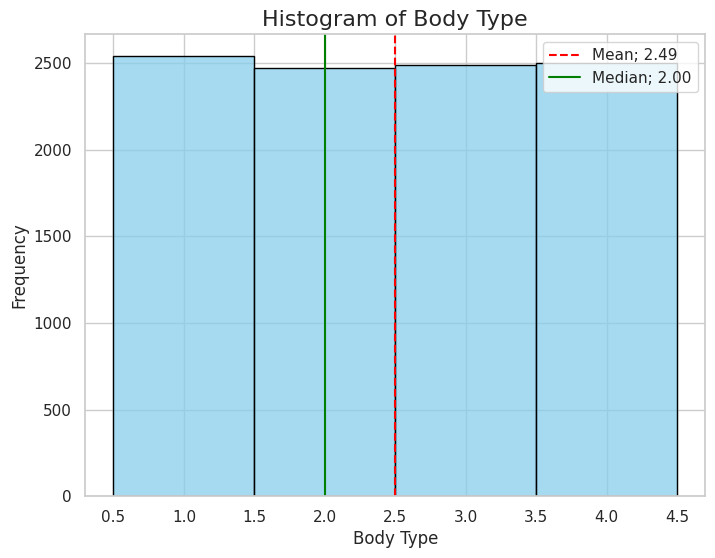

In [15]:
mean=column_dict['Body Type']['mean']
median=column_dict['Body Type']['median']
reverse_body_weight_mapper={v:k for k,v in body_weight_mapper.items()}

histogram_sns('Body Type',dataset_encoded,mean,median)

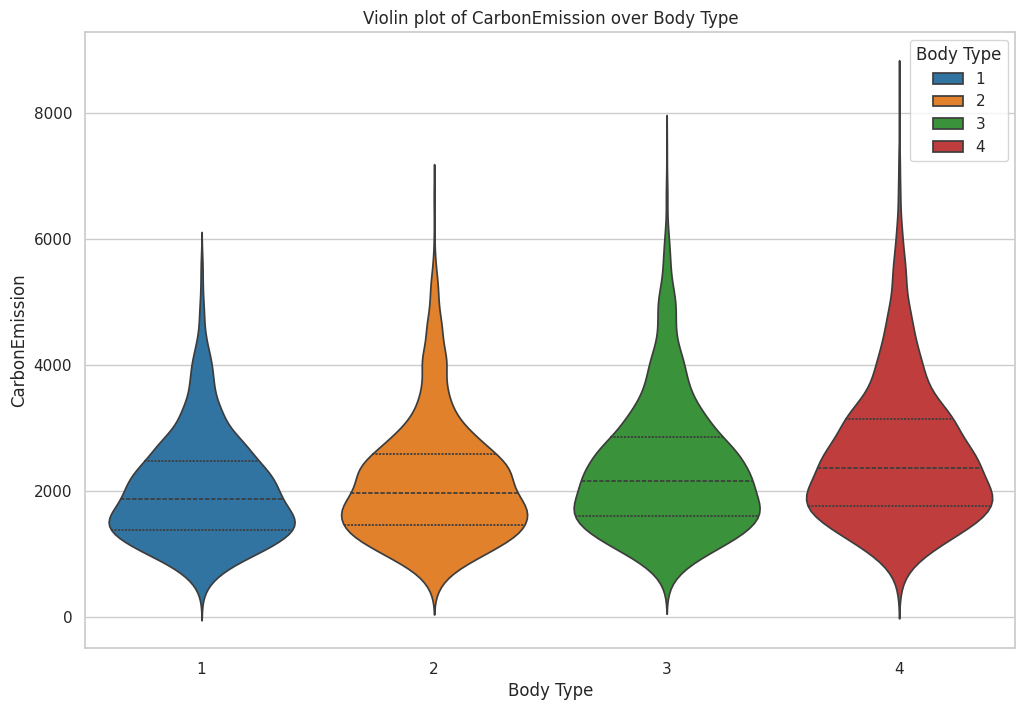

In [16]:
violin_sns(dataset_encoded,'Body Type','CarbonEmission')

/tmp/ipykernel_31624/1768541527.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


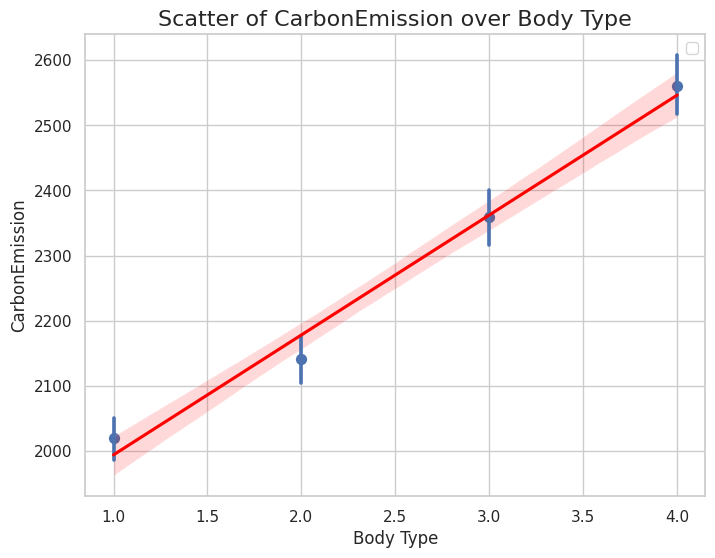

In [17]:
scatter_sns(dataset_encoded,'Body Type', 'CarbonEmission',estimator=np.mean,robust=False)

In [18]:
df_corr=dataset_encoded.corr()['Body Type']
display(df_corr.sort_values(ascending=False,key=lambda x: np.abs(x)))

Body Type                        1.000000
CarbonEmission                   0.203169
Waste Bag Size                   0.026214
vegan                           -0.018800
Plastic                          0.018364
vegetarian                       0.017712
walk/bicycle                    -0.015092
public                           0.013366
coal                            -0.013164
lpg                              0.012673
Paper                            0.012639
natural gas                      0.009323
electricity                      0.008901
Monthly Grocery Bill            -0.008610
Microwave                       -0.008491
Social Activity                 -0.007824
omnivore                         0.007463
Vehicle Monthly Distance Km      0.007428
Grill                            0.007214
Airfryer                         0.007214
diesel                          -0.006905
Glass                            0.006400
pescatarian                     -0.006228
Waste Bag Weekly Count          -0

Ne postoji kolona koja ima značajniji stepen korelacije sa kolonom Body Type osim target kolone.

### How Often Shower

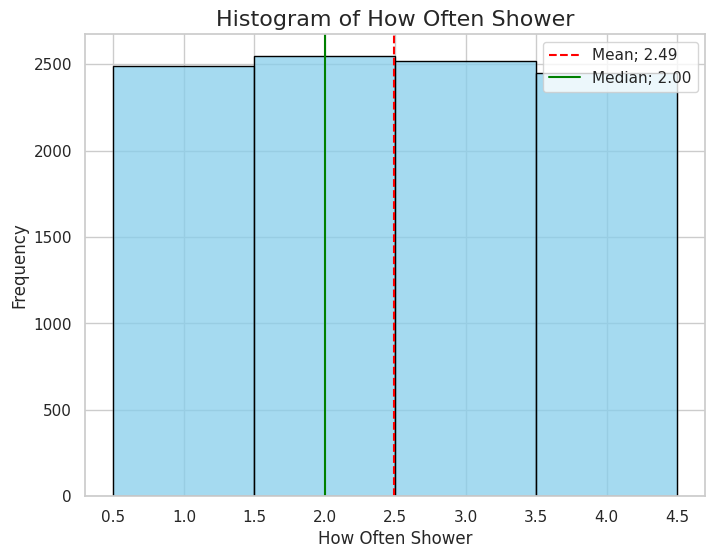

In [19]:
mean=column_dict['How Often Shower']['mean']
median=column_dict['How Often Shower']['median']
reverse_shower_mapper={v:k for k,v in shower_mapper.items()}

histogram_sns('How Often Shower',dataset_encoded,mean,median)

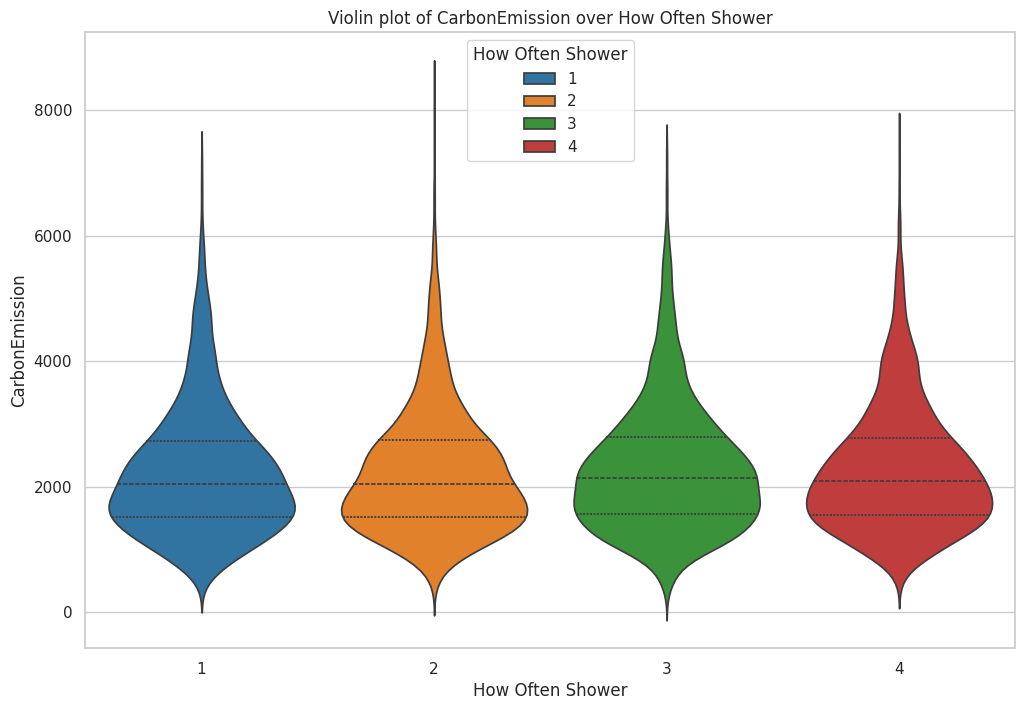

In [20]:
violin_sns(dataset_encoded,'How Often Shower','CarbonEmission')

/tmp/ipykernel_31624/1768541527.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


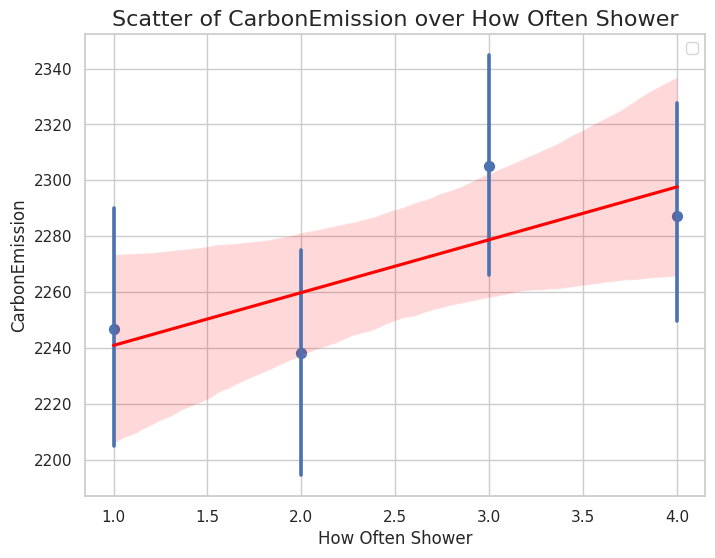

In [21]:
scatter_sns(dataset_encoded,'How Often Shower', 'CarbonEmission',estimator=np.mean,robust=False)

In [22]:
df_corr=dataset_encoded.corr()['How Often Shower']
display(df_corr.sort_values(ascending=False,key=lambda x: np.abs(x)))

How Often Shower                 1.000000
vegetarian                       0.023063
CarbonEmission                   0.020685
Oven                             0.019569
Metal                            0.018936
Monthly Grocery Bill             0.018562
Microwave                        0.017711
Paper                            0.016871
Vehicle Monthly Distance Km      0.016249
hybrid                           0.015927
How Long Internet Daily Hour     0.015847
How Many New Clothes Monthly     0.014920
Glass                            0.014716
pescatarian                     -0.014713
female                           0.012773
male                            -0.012773
wood                             0.010952
Grill                            0.009429
Airfryer                         0.009429
coal                            -0.009125
Social Activity                 -0.008452
private                          0.007875
vegan                           -0.007533
Waste Bag Size                   0

Ne postoji kolona koja ima značajniji stepen korelacije sa kolonom How Often Shower.

### Social Activity

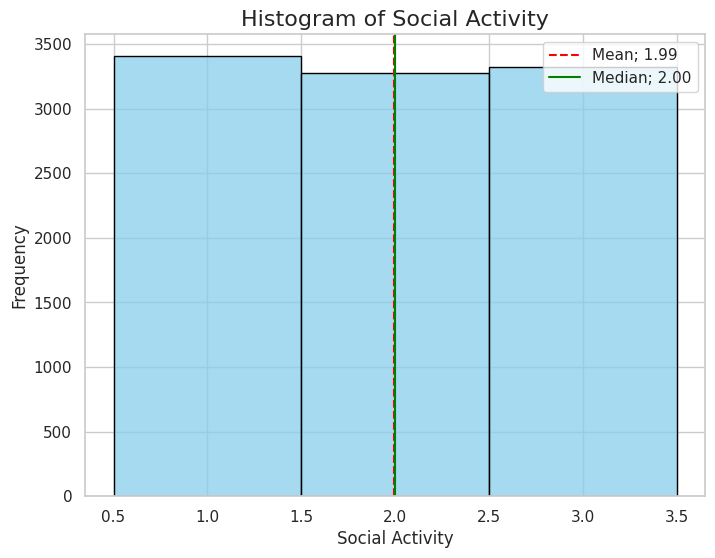

In [23]:
mean=column_dict['Social Activity']['mean']
median=column_dict['Social Activity']['median']
reverse_shower_mapper={v:k for k,v in shower_mapper.items()}

histogram_sns('Social Activity',dataset_encoded,mean,median)

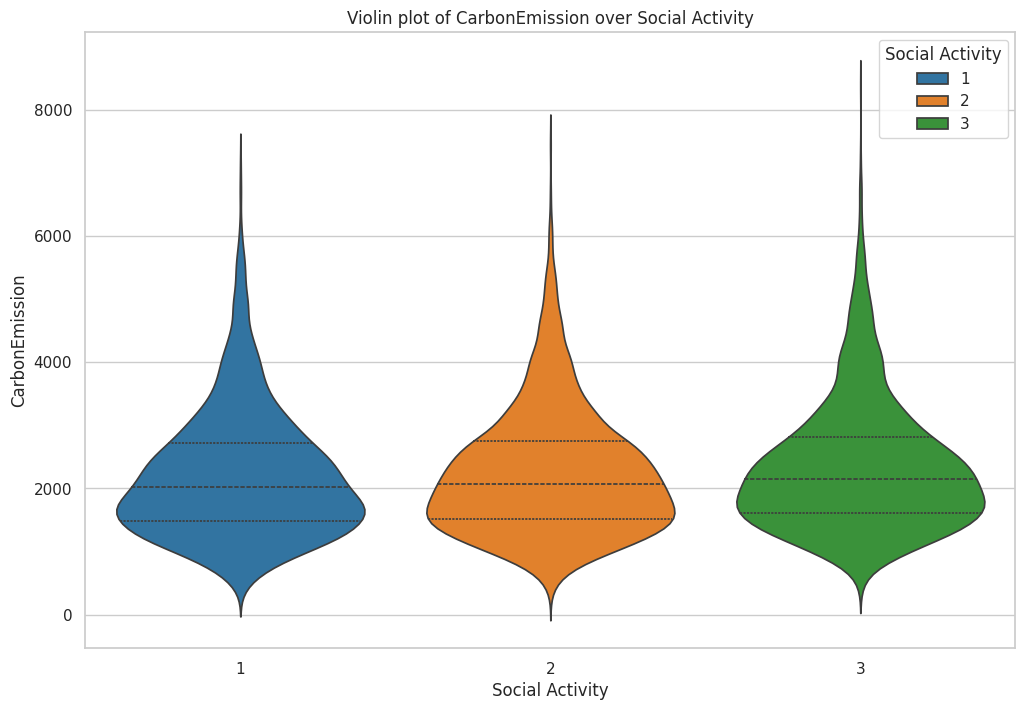

In [24]:
violin_sns(dataset_encoded,'Social Activity','CarbonEmission')

/tmp/ipykernel_31624/1768541527.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


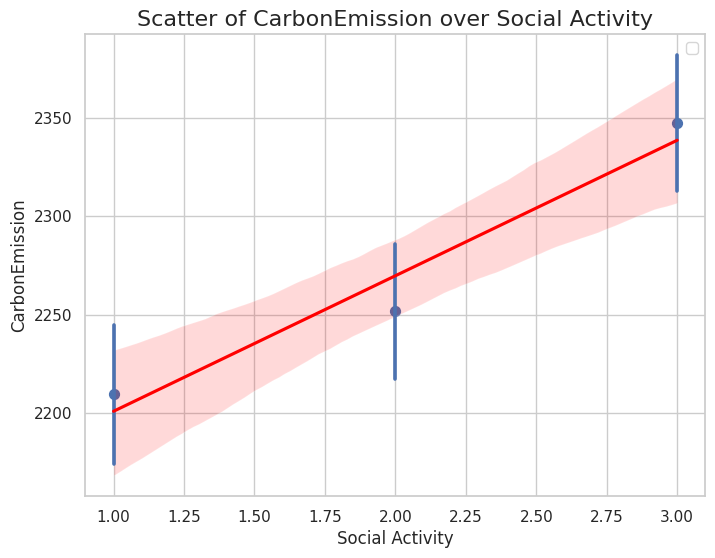

In [25]:
scatter_sns(dataset_encoded,'Social Activity', 'CarbonEmission',estimator=np.mean,robust=False)

In [26]:
df_corr=dataset_encoded.corr()['Social Activity']
display(df_corr.sort_values(ascending=False,key=lambda x: np.abs(x)))

Social Activity                  1.000000
CarbonEmission                   0.055376
Waste Bag Size                  -0.019345
How Long Internet Daily Hour     0.015826
vegan                           -0.015574
Paper                           -0.013097
electricity                     -0.013090
How Many New Clothes Monthly    -0.012831
Metal                            0.012173
Airfryer                         0.010349
Grill                            0.010349
Frequency of Traveling by Air   -0.009626
omnivore                         0.009214
male                            -0.009161
female                           0.009161
wood                             0.008895
How Often Shower                -0.008452
Stove                            0.008258
vegetarian                       0.008038
Body Type                       -0.007824
lpg                             -0.007632
walk/bicycle                     0.007147
Energy efficiency               -0.006211
coal                             0

Nema kolona sa značajnijim stepenom koerlacije sa kolonom Social Activity

### Frequency of Traveling by Air

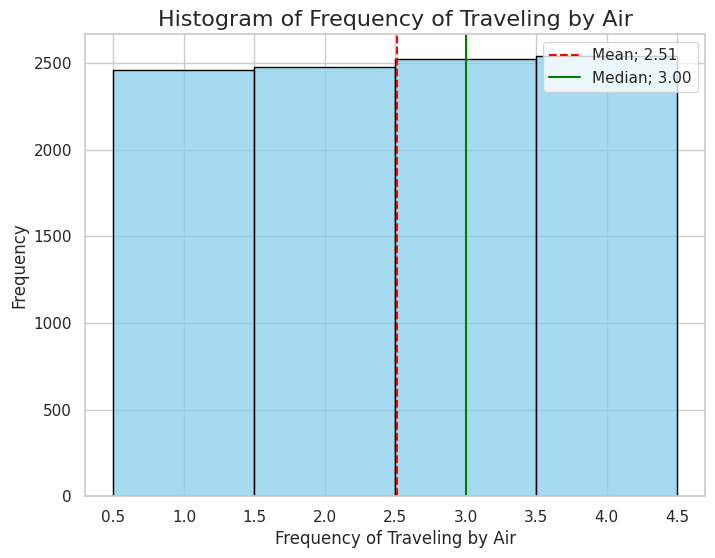

In [27]:
mean=column_dict['Frequency of Traveling by Air']['mean']
median=column_dict['Frequency of Traveling by Air']['median']
reverse_shower_mapper={v:k for k,v in shower_mapper.items()}

histogram_sns('Frequency of Traveling by Air',dataset_encoded,mean,median)

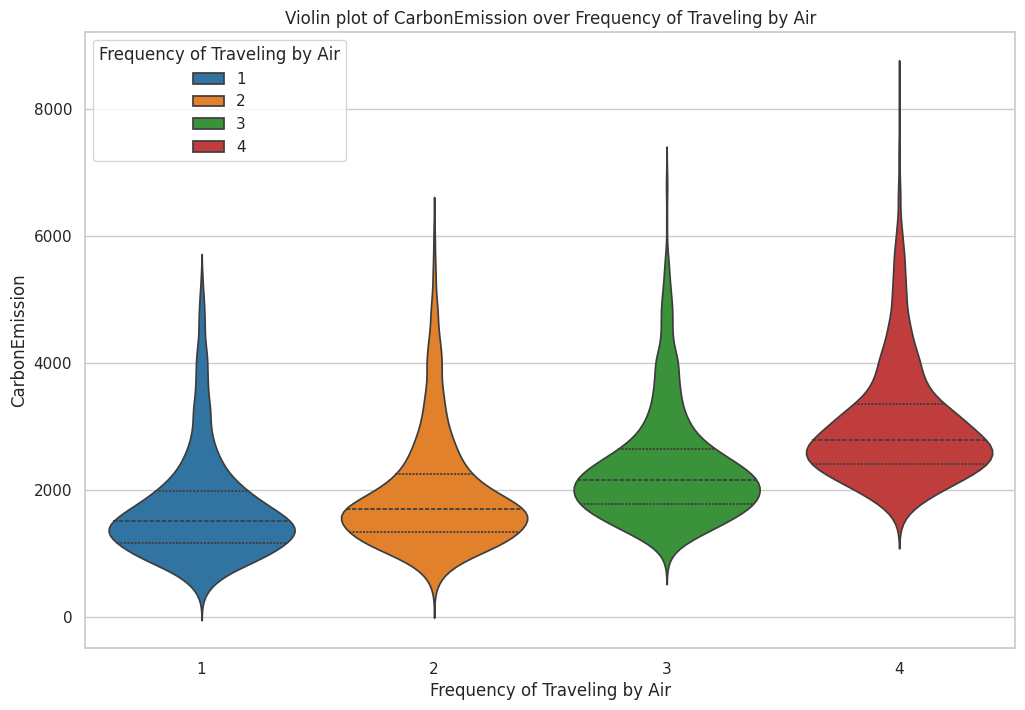

In [28]:
violin_sns(dataset_encoded,'Frequency of Traveling by Air','CarbonEmission')

/tmp/ipykernel_31624/1768541527.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


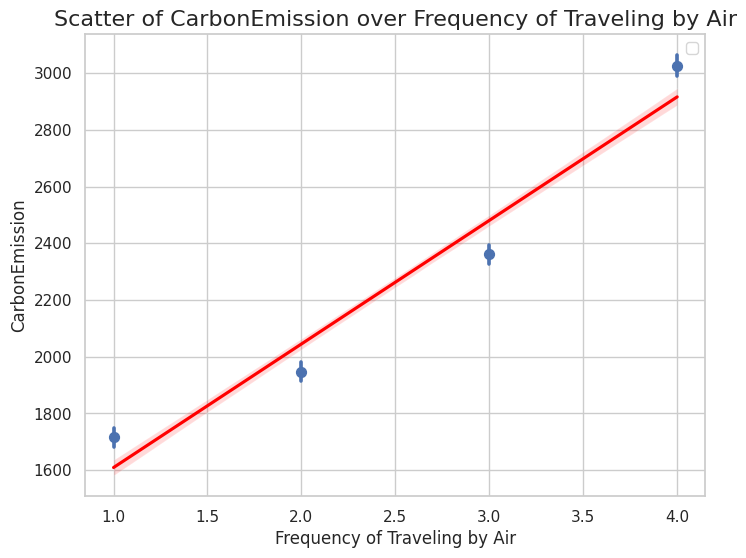

In [29]:
scatter_sns(dataset_encoded,'Frequency of Traveling by Air', 'CarbonEmission',estimator=np.mean,robust=False)

In [30]:
df_corr=dataset_encoded.corr()['Frequency of Traveling by Air']
display(df_corr.sort_values(ascending=False,key=lambda x: np.abs(x)))

Frequency of Traveling by Air    1.000000
CarbonEmission                   0.478487
diesel                           0.021846
natural gas                     -0.021741
vegan                            0.020108
Waste Bag Size                  -0.017660
Microwave                       -0.013073
wood                             0.012829
electric                        -0.010451
vegetarian                      -0.010208
Social Activity                 -0.009626
Oven                             0.009264
How Long Internet Daily Hour    -0.008512
How Long TV PC Daily Hour       -0.007707
private                          0.007233
lpg                              0.007164
Plastic                         -0.006970
Stove                           -0.006548
Waste Bag Weekly Count           0.006537
Metal                            0.006319
coal                             0.005956
omnivore                        -0.005612
Grill                           -0.005257
Airfryer                        -0

Nema kolona koje imaju značajniji stepen korelacije sa kolonom Frequency of Traveling by Air osim target kolone.

### Waste Bag Size

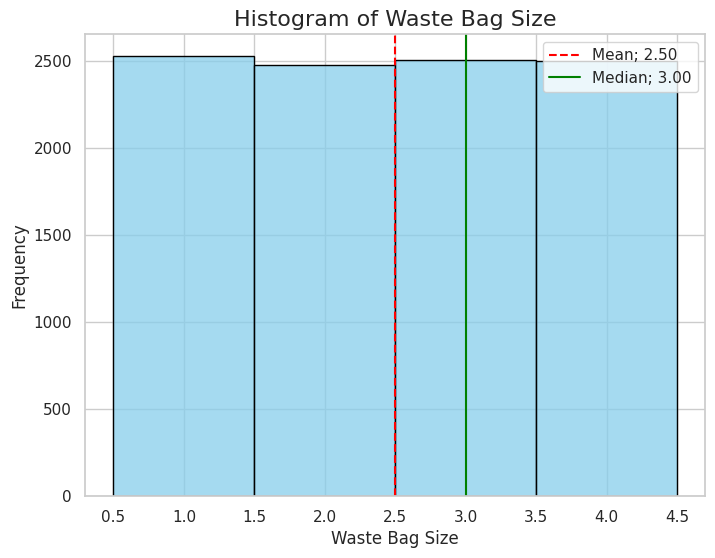

In [31]:
mean=column_dict['Waste Bag Size']['mean']
median=column_dict['Waste Bag Size']['median']
reverse_shower_mapper={v:k for k,v in shower_mapper.items()}

histogram_sns('Waste Bag Size',dataset_encoded,mean,median)

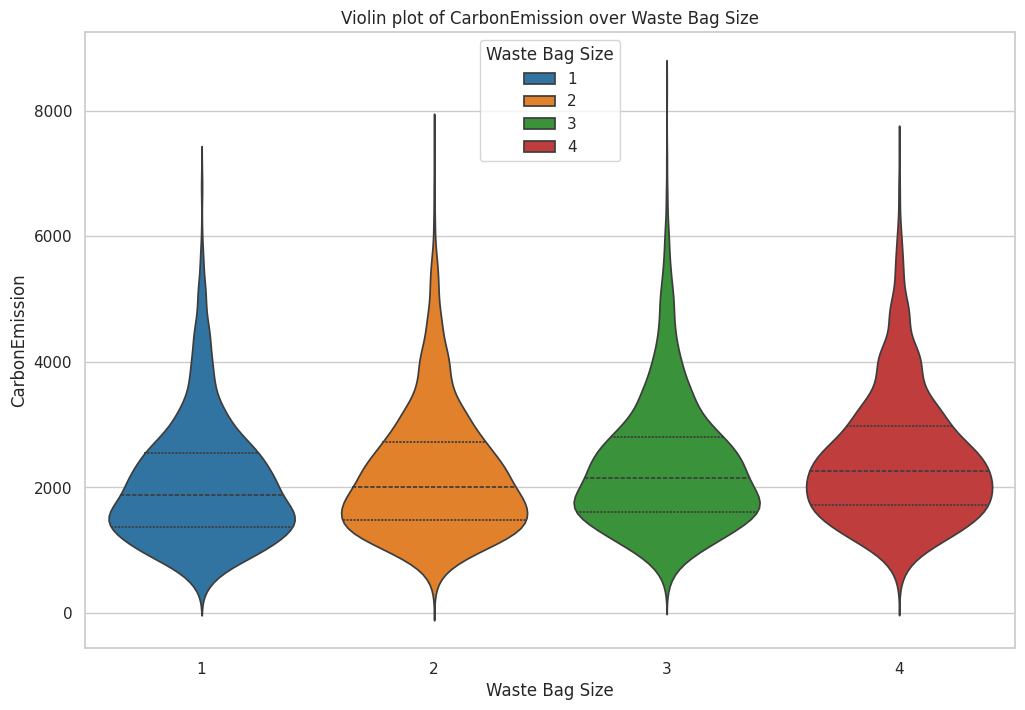

In [32]:
violin_sns(dataset_encoded,'Waste Bag Size','CarbonEmission')

/tmp/ipykernel_31624/1768541527.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


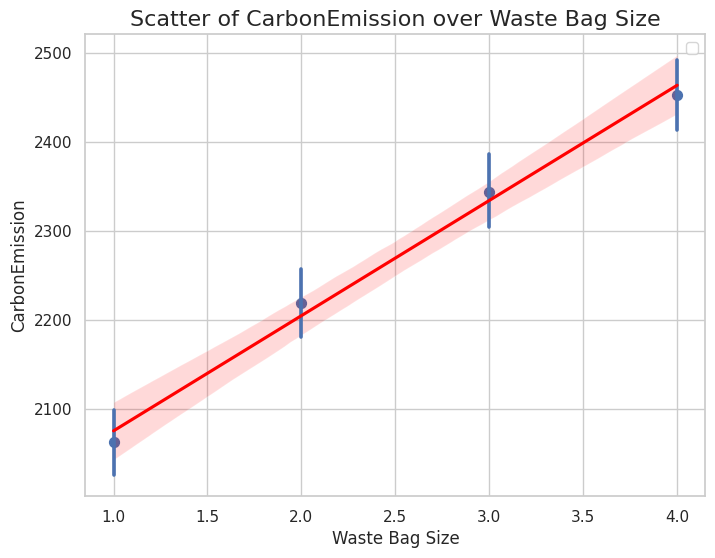

In [33]:
scatter_sns(dataset_encoded,'Waste Bag Size', 'CarbonEmission',estimator=np.mean,robust=False)

In [34]:
df_corr=dataset_encoded.corr()['Waste Bag Size']
display(df_corr.sort_values(ascending=False,key=lambda x: np.abs(x)))

Waste Bag Size                   1.000000
CarbonEmission                   0.142395
Body Type                        0.026214
Grill                            0.021242
Airfryer                         0.021242
Monthly Grocery Bill             0.021008
Social Activity                 -0.019345
Frequency of Traveling by Air   -0.017660
diesel                           0.016075
Vehicle Monthly Distance Km      0.015121
Energy efficiency                0.014765
Waste Bag Weekly Count           0.012540
electric                         0.012527
Stove                            0.012426
petrol                          -0.012318
female                           0.011161
male                            -0.011161
Plastic                         -0.010267
Oven                            -0.009977
public                          -0.007805
How Often Shower                 0.007409
natural gas                      0.007233
vegan                           -0.005673
coal                            -0

Nema kolona koje imaju značajniji stepen korelacije sa kolonom Waste Bag size osim target kolone. Kao mogući feature engineering može se kolona Waste Bag Size ukombinovati sa kolonom Waste Bag Weekly jer nijedna od njih ne daje punu informaciju sama sa sobom.

### Energy efficiency

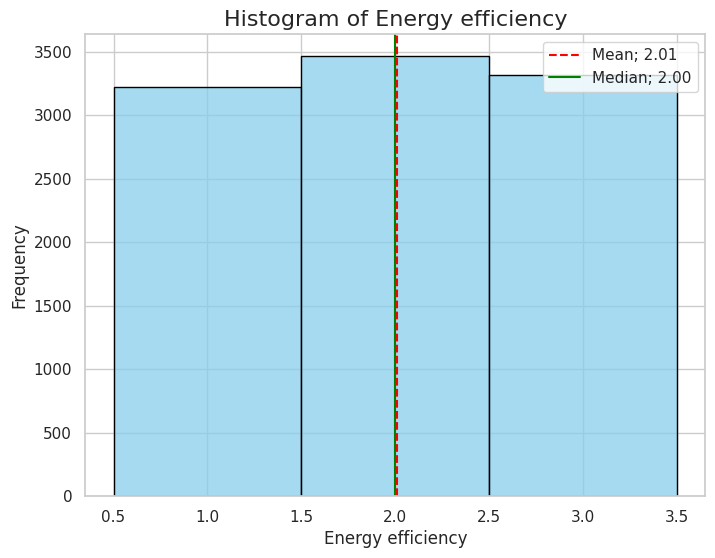

In [35]:
mean=column_dict['Energy efficiency']['mean']
median=column_dict['Energy efficiency']['median']
reverse_shower_mapper={v:k for k,v in shower_mapper.items()}

histogram_sns('Energy efficiency',dataset_encoded,mean,median)

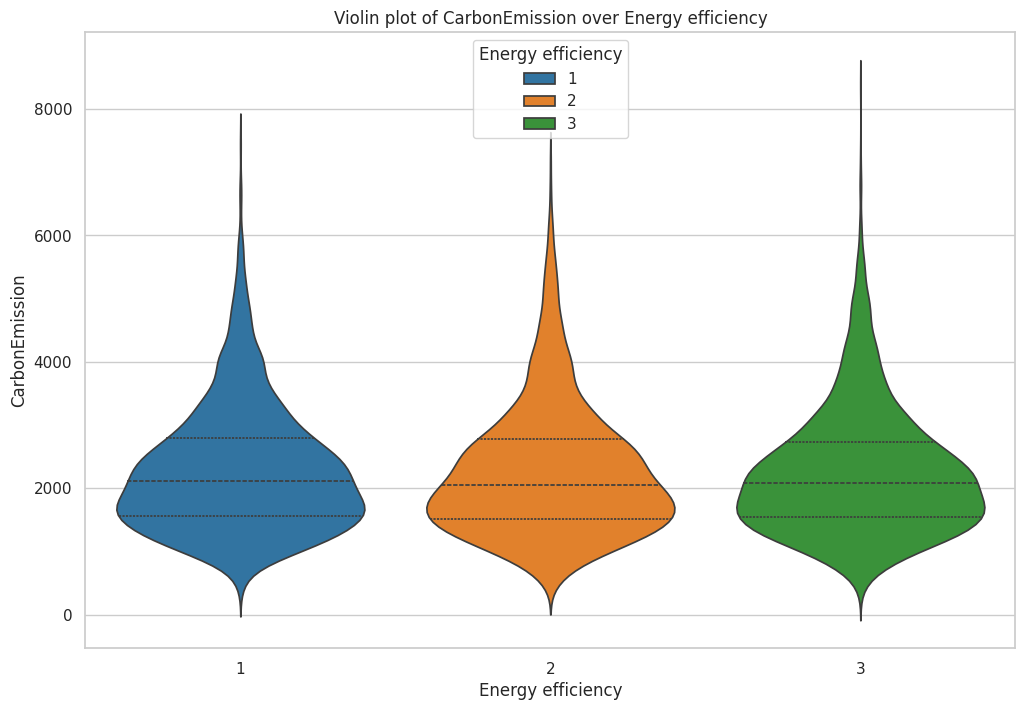

In [36]:
violin_sns(dataset_encoded,'Energy efficiency','CarbonEmission')

/tmp/ipykernel_31624/1768541527.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


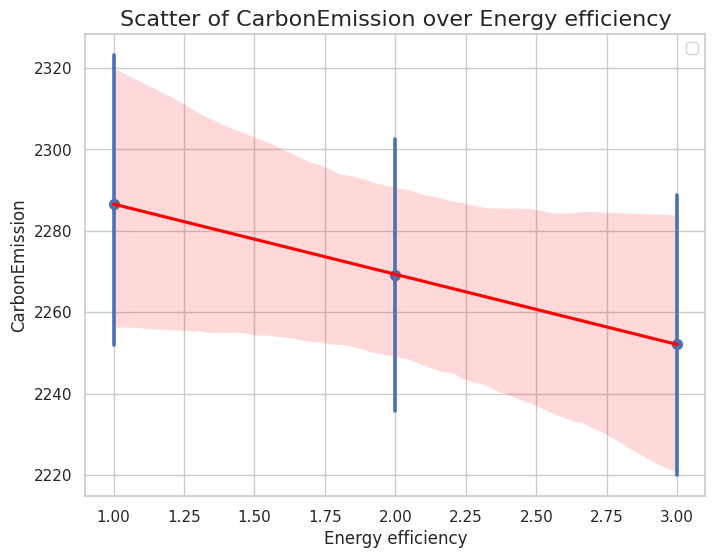

In [37]:
scatter_sns(dataset_encoded,'Energy efficiency', 'CarbonEmission',estimator=np.mean,robust=False)

In [38]:
df_corr=dataset_encoded.corr()['Energy efficiency']
display(df_corr.sort_values(ascending=False,key=lambda x: np.abs(x)))

Energy efficiency                1.000000
Metal                           -0.031653
wood                             0.026297
private                          0.019985
Monthly Grocery Bill             0.018164
omnivore                        -0.017636
Oven                            -0.015827
Waste Bag Size                   0.014765
lpg                              0.013785
CarbonEmission                  -0.013712
electric                         0.013658
How Long Internet Daily Hour    -0.012501
walk/bicycle                    -0.012133
Vehicle Monthly Distance Km      0.012017
pescatarian                      0.011555
male                             0.011025
female                          -0.011025
coal                            -0.009959
hybrid                           0.009538
vegan                            0.009510
electricity                     -0.009148
public                          -0.007709
natural gas                     -0.007003
Glass                           -0

Nema kolona koje imaju značajniji stepen korelacije sa kolonom Energy efficiency.

### Sex

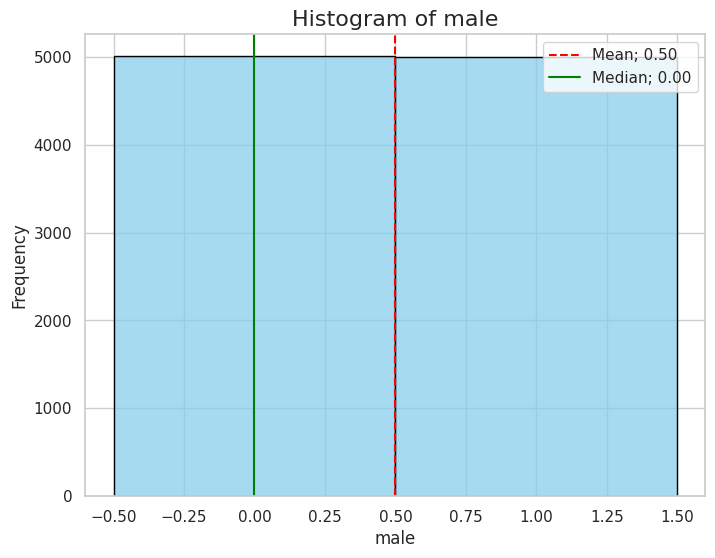

In [39]:
mean=column_dict['male']['mean']
median=column_dict['male']['median']
reverse_shower_mapper={v:k for k,v in shower_mapper.items()}

histogram_sns('male',dataset_encoded,mean,median)

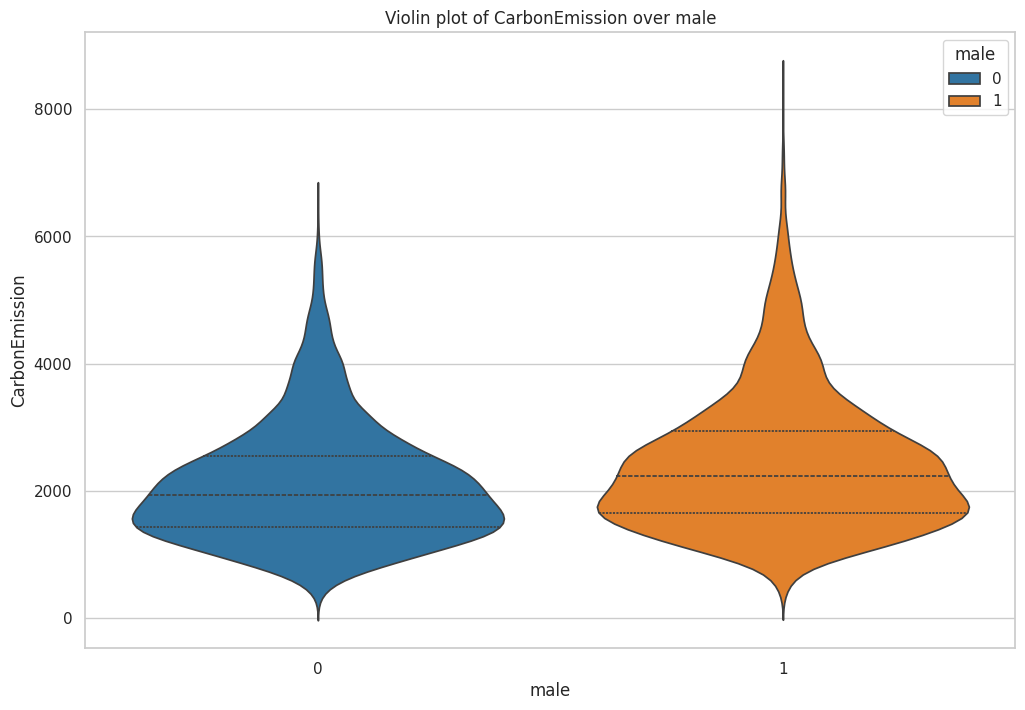

In [40]:
violin_sns(dataset_encoded,'male','CarbonEmission')

/tmp/ipykernel_31624/1768541527.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


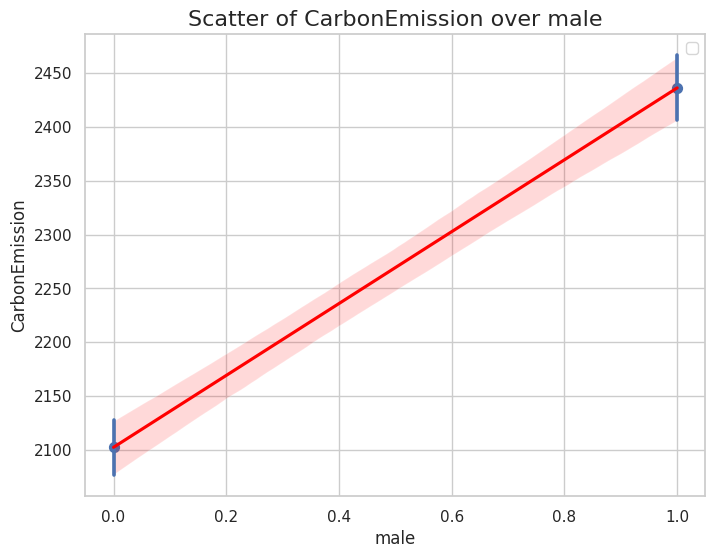

In [41]:
scatter_sns(dataset_encoded,'male', 'CarbonEmission',estimator=np.mean,robust=False)

In [42]:
df_corr=dataset_encoded.corr()['male']
display(df_corr.sort_values(ascending=False,key=lambda x: np.abs(x)))

female                          -1.000000
male                             1.000000
CarbonEmission                   0.163895
Glass                            0.021994
natural gas                      0.021227
Monthly Grocery Bill             0.015877
coal                            -0.014152
Metal                           -0.013587
diesel                           0.012782
How Often Shower                -0.012773
hybrid                          -0.011873
Paper                           -0.011607
Waste Bag Size                  -0.011161
electricity                     -0.011108
Energy efficiency                0.011025
walk/bicycle                    -0.009313
Social Activity                 -0.009161
Grill                           -0.008602
Airfryer                        -0.008602
petrol                           0.008092
Microwave                       -0.007980
public                           0.007364
Plastic                         -0.007201
How Long TV PC Daily Hour        0

Nema kolona sa značajnijim koeficijentom korelacije u odnosu na male kolonu osim target kolone.

Kako je ova kolona suprotna koloni female dovoljno je izvršiti analizu nad samo jednom od njih.

### Diet

/tmp/ipykernel_31624/1768541527.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


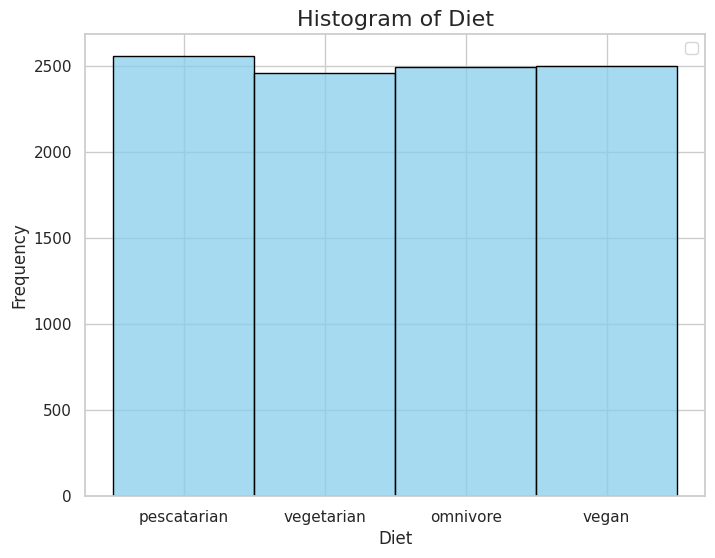

In [43]:
histogram_sns('Diet',dataset)

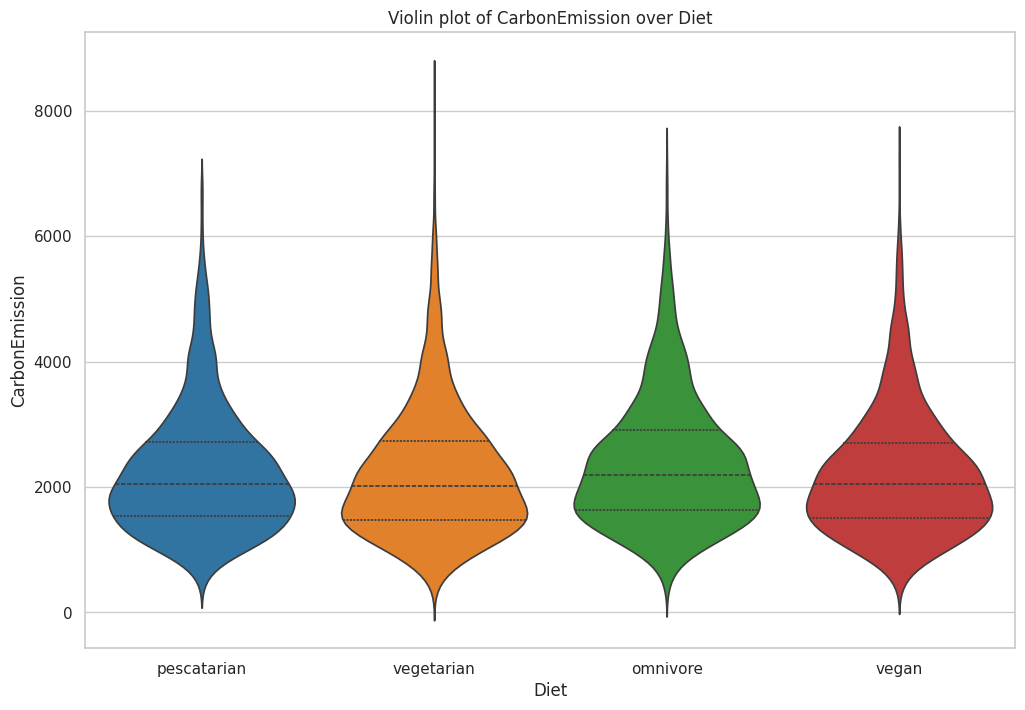

In [44]:
violin_sns(dataset,'Diet','CarbonEmission')

### Heating Energy Source

/tmp/ipykernel_31624/1768541527.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


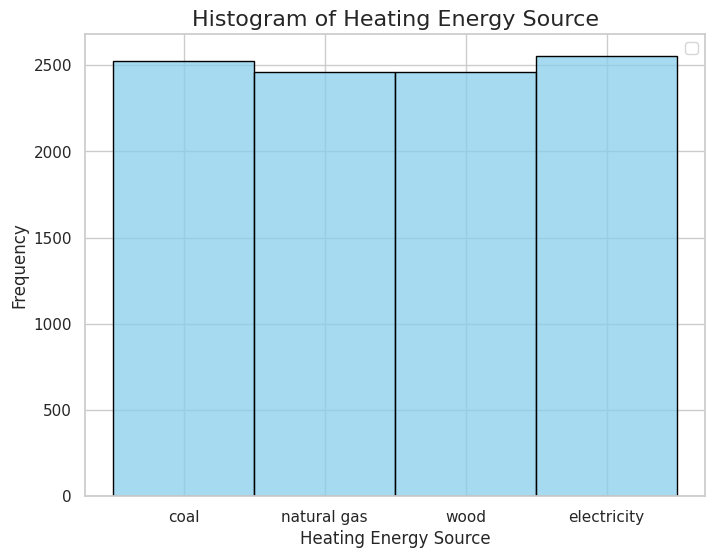

In [45]:
histogram_sns('Heating Energy Source',dataset)

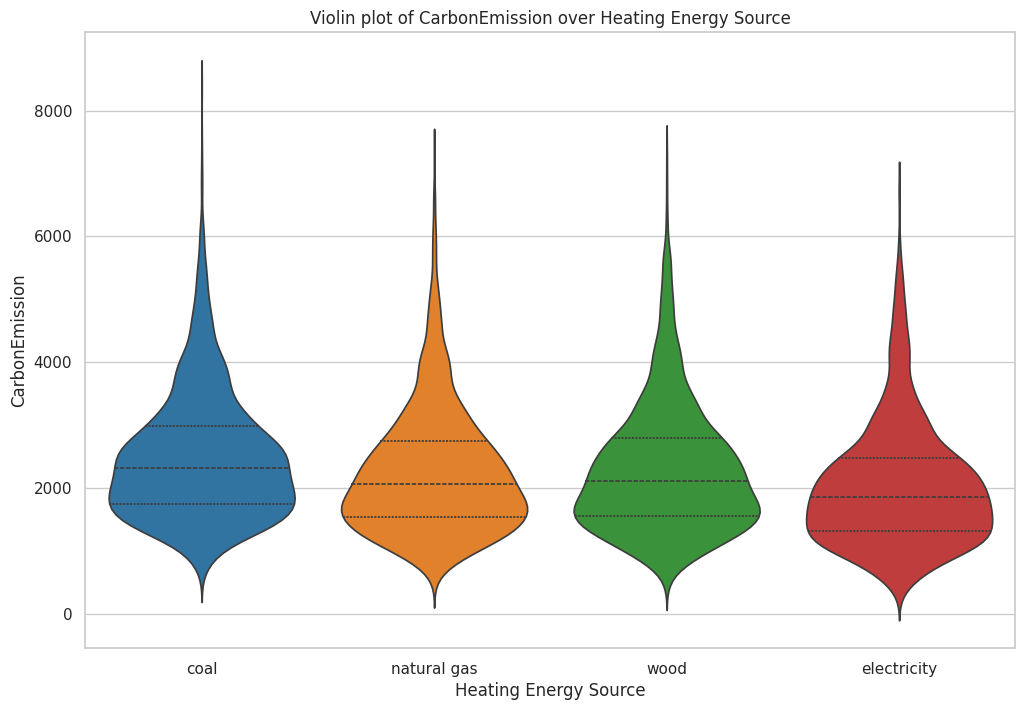

In [46]:
violin_sns(dataset,'Heating Energy Source','CarbonEmission')

### Transport

/tmp/ipykernel_31624/1768541527.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


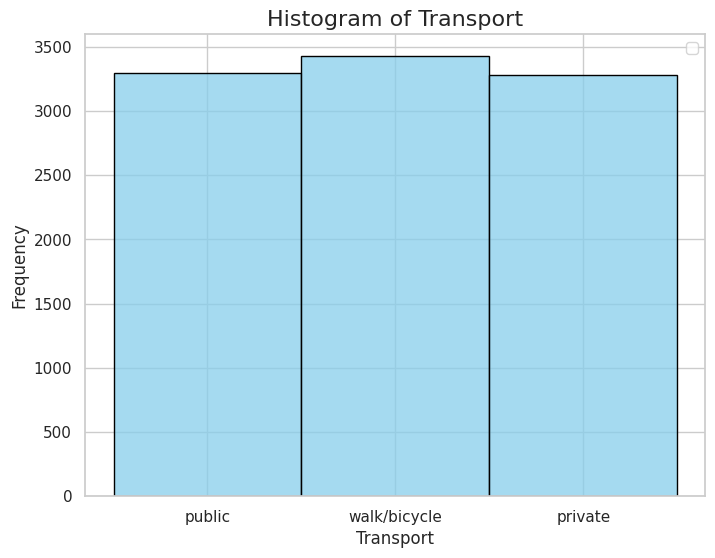

In [47]:
histogram_sns('Transport',dataset)

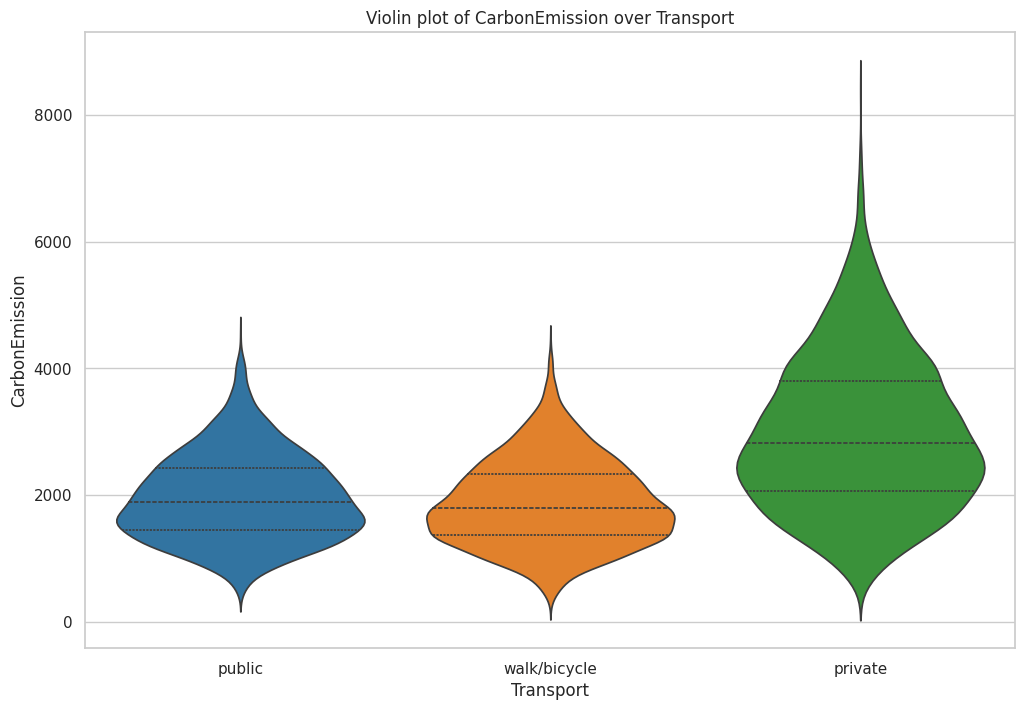

In [48]:
violin_sns(dataset,'Transport','CarbonEmission')

### Vehicle Type

/tmp/ipykernel_31624/1768541527.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


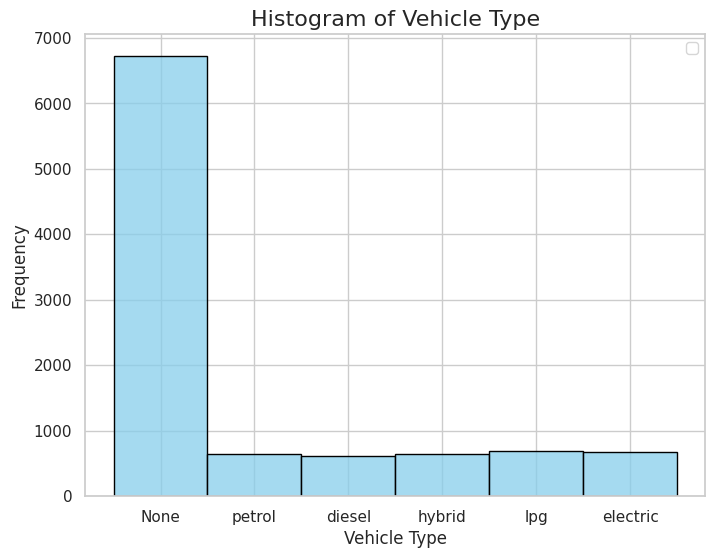

In [49]:
dataset_nan_encoded=dataset.copy(deep=True)
dataset_nan_encoded['Vehicle Type'] = dataset_nan_encoded['Vehicle Type'].astype('object')
dataset_nan_encoded.loc[dataset_nan_encoded['Vehicle Type'].isnull(), 'Vehicle Type'] = 'None'
histogram_sns('Vehicle Type',dataset_nan_encoded)

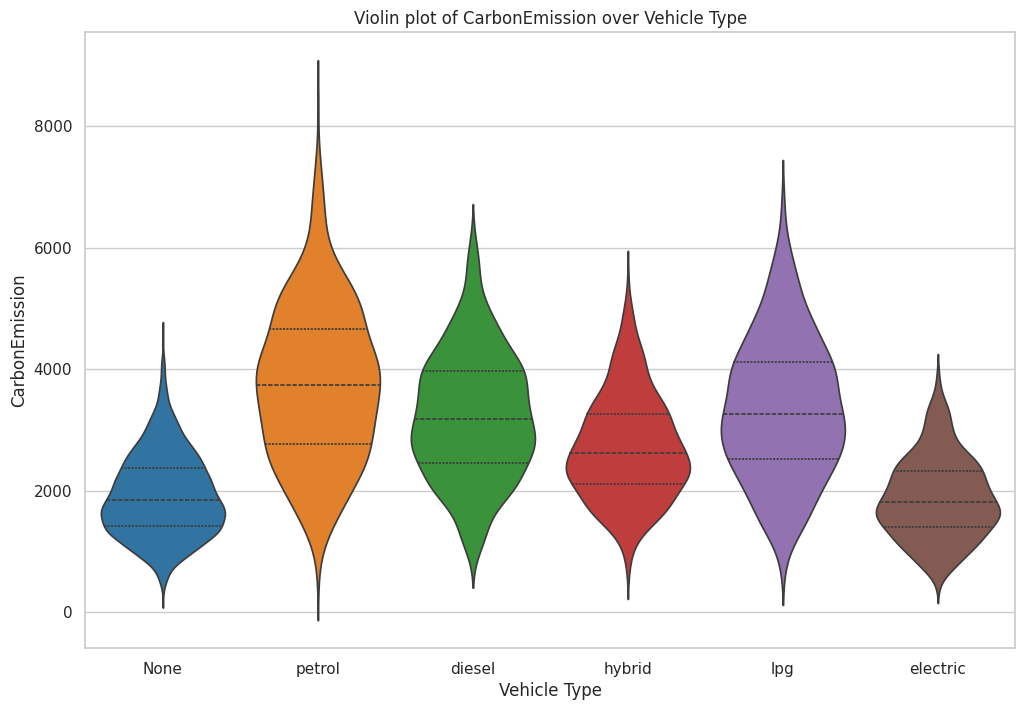

In [50]:
violin_sns(dataset_nan_encoded,'Vehicle Type','CarbonEmission')

### Recycling

In [51]:
metal=dataset_encoded[dataset_encoded['Metal']==1].count().values[0]
plastic=dataset_encoded[dataset_encoded['Plastic']==1].count().values[0]
glass=dataset_encoded[dataset_encoded['Glass']==1].count().values[0]
paper=dataset_encoded[dataset_encoded['Paper']==1].count().values[0]
x=['Metal','Plastic','Glass','Paper']
y=[metal,plastic,glass,paper]
temp=pd.DataFrame({'Materials':x,'Counts':y})
fig=go.Figure()
fig.add_trace(
    go.Bar(
        x=x,
        y=y,
        marker=dict(
            color='skyblue',
            line=dict(
                color='black',
                width=1
            ),
        ),
        opacity=0.5,
        name='Recycling',n
    )
)
fig.update_layout(
    title=f'Histogram of Recycling',
    xaxis_title='Materials',
    yaxis_title='Frequency',
    width=700,
    height=500,
    legend_title='Legend'
)
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)
fig.show()

SyntaxError: positional argument follows keyword argument (2563825699.py, line 22)

### Cooking_With

In [52]:
stove=dataset_encoded[dataset_encoded['Stove']==1].count().values[0]
oven=dataset_encoded[dataset_encoded['Oven']==1].count().values[0]
microwave=dataset_encoded[dataset_encoded['Microwave']==1].count().values[0]
grill=dataset_encoded[dataset_encoded['Grill']==1].count().values[0]
airfryer=dataset_encoded[dataset_encoded['Airfryer']==1].count().values[0]
x=['Stove','Oven','Microwave','Grill', 'Airfryer']
y=[stove,oven,microwave,grill,airfryer]
temp=pd.DataFrame({'Devices':x,'Counts':y})
fig=go.Figure()
fig.add_trace(
    go.Bar(
        x=x,
        y=y,
        marker=dict(
            color='skyblue',
            line=dict(
                color='black',
                width=1
            ),
        ),
        opacity=0.5,
        name='Cooking_With',
    )
)
fig.update_layout(
    title=f'Histogram of Cooking_With',
    xaxis_title='Devices',
    yaxis_title='Frequency',
    width=700,
    height=500,
    legend_title='Legend'
)
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)
fig.show()

### Monthly Grocery Bill

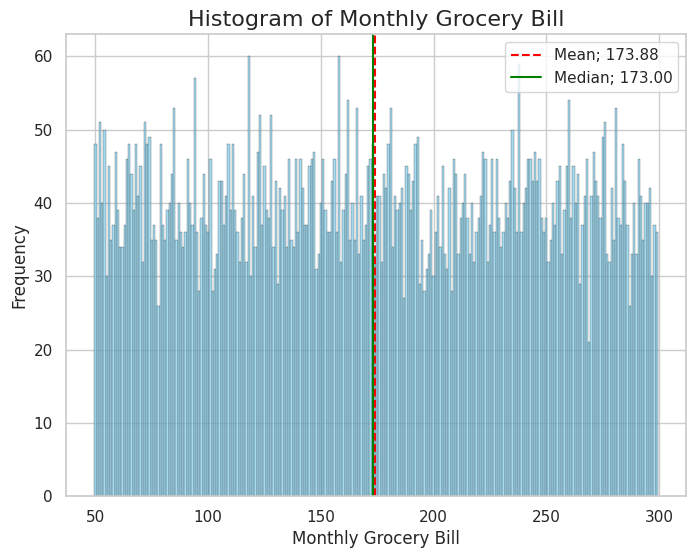

In [53]:
mean=column_dict['Monthly Grocery Bill']['mean']
median=column_dict['Monthly Grocery Bill']['median']

histogram_sns('Monthly Grocery Bill',dataset_encoded,mean,median)

/tmp/ipykernel_31624/1768541527.py:61: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



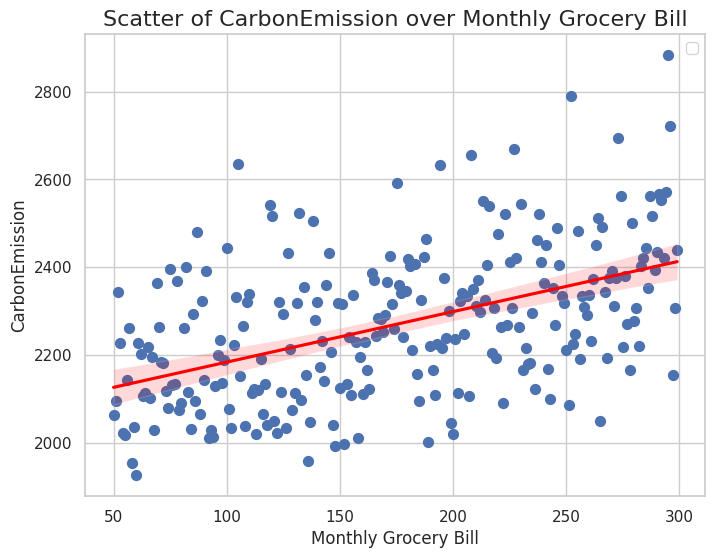

In [54]:
scatter_sns(dataset_encoded,'Monthly Grocery Bill', 'CarbonEmission',estimator=np.mean,robust=False,x_ci=None)

In [55]:
df_corr=dataset_encoded.corr()['Monthly Grocery Bill']
display(df_corr.sort_values(ascending=False,key=lambda x: np.abs(x)))

Monthly Grocery Bill             1.000000
CarbonEmission                   0.081587
Waste Bag Size                   0.021008
How Often Shower                 0.018562
Energy efficiency                0.018164
Stove                            0.017146
vegan                           -0.017085
petrol                           0.015982
male                             0.015877
female                          -0.015877
Vehicle Monthly Distance Km      0.015801
Airfryer                         0.015589
Grill                            0.015589
walk/bicycle                    -0.013723
How Long Internet Daily Hour     0.012798
public                           0.012245
How Long TV PC Daily Hour       -0.010318
pescatarian                      0.009993
Paper                            0.009329
Metal                           -0.009299
natural gas                      0.009231
coal                            -0.008957
Body Type                       -0.008610
Oven                             0

### Vehicle Monthly Distance Km

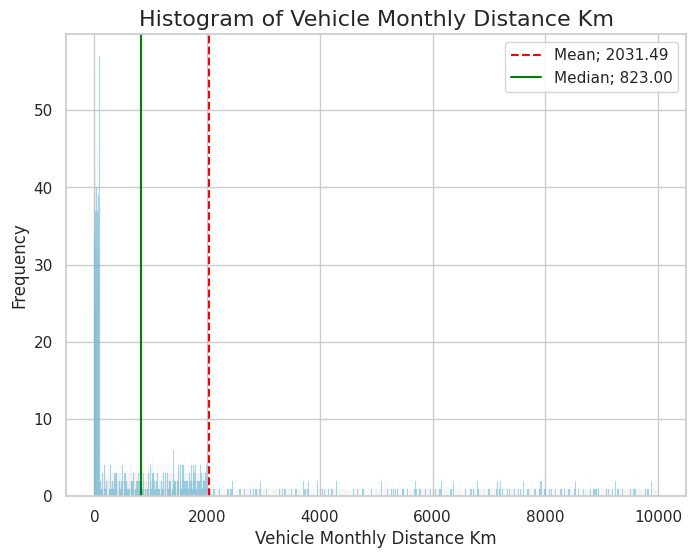

In [56]:
mean=column_dict['Vehicle Monthly Distance Km']['mean']
median=column_dict['Vehicle Monthly Distance Km']['median']

histogram_sns('Vehicle Monthly Distance Km',dataset_encoded,mean,median)

/tmp/ipykernel_31624/1768541527.py:61: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



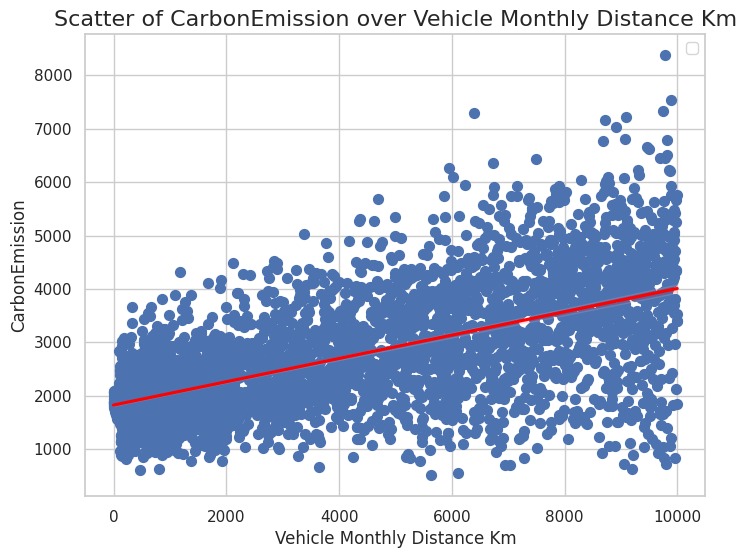

In [57]:
scatter_sns(dataset_encoded,'Vehicle Monthly Distance Km', 'CarbonEmission',estimator=np.mean,robust=False,x_ci=None)

In [58]:
df_corr=dataset_encoded.corr()['Vehicle Monthly Distance Km']
display(df_corr.sort_values(ascending=False,key=lambda x: np.abs(x)))

Vehicle Monthly Distance Km      1.000000
private                          0.777946
CarbonEmission                   0.594171
walk/bicycle                    -0.516658
lpg                              0.319735
electric                         0.294403
hybrid                           0.287796
diesel                           0.286564
petrol                           0.286093
public                          -0.255308
omnivore                         0.027378
Metal                           -0.017488
natural gas                     -0.016752
pescatarian                     -0.016302
How Often Shower                 0.016249
Monthly Grocery Bill             0.015801
Waste Bag Size                   0.015121
vegetarian                      -0.014869
coal                             0.014508
Oven                             0.014096
Paper                           -0.012647
Energy efficiency                0.012017
Stove                           -0.008685
Body Type                        0

Kako postoji visok nivo korelisanosti kolone Vehicle Monthlz DIstance Km i kolone private moguće je izbaciti jednu od njih kao deo preprocessing-a dataset-a.

### Waste Bag Weekly Count

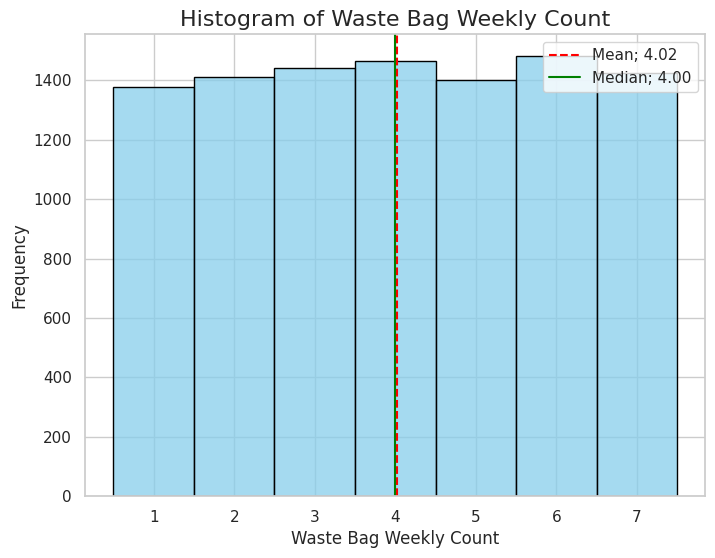

In [59]:
mean=column_dict['Waste Bag Weekly Count']['mean']
median=column_dict['Waste Bag Weekly Count']['median']

histogram_sns('Waste Bag Weekly Count',dataset_encoded,mean,median)

/tmp/ipykernel_31624/1768541527.py:61: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



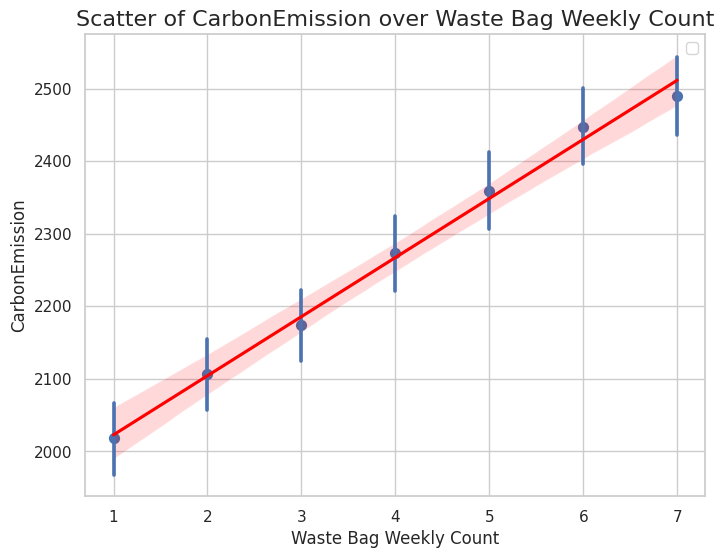

In [60]:
scatter_sns(dataset_encoded,'Waste Bag Weekly Count', 'CarbonEmission',estimator=np.mean,robust=False)

In [61]:
df_corr=dataset_encoded.corr()['Waste Bag Weekly Count']
display(df_corr.sort_values(ascending=False,key=lambda x: np.abs(x)))

Waste Bag Weekly Count           1.000000
CarbonEmission                   0.159193
public                           0.016674
Microwave                        0.015698
Metal                            0.014455
Waste Bag Size                   0.012540
How Long TV PC Daily Hour       -0.011640
private                         -0.010881
natural gas                      0.010431
electric                        -0.009942
pescatarian                     -0.009889
vegetarian                       0.009869
coal                            -0.008915
Paper                            0.007192
Frequency of Traveling by Air    0.006537
Glass                           -0.006379
walk/bicycle                    -0.005749
Stove                            0.005627
Body Type                       -0.005586
How Long Internet Daily Hour    -0.005335
Grill                            0.004441
Airfryer                         0.004441
lpg                             -0.004172
petrol                          -0

### How Long TV PC Daily Hour

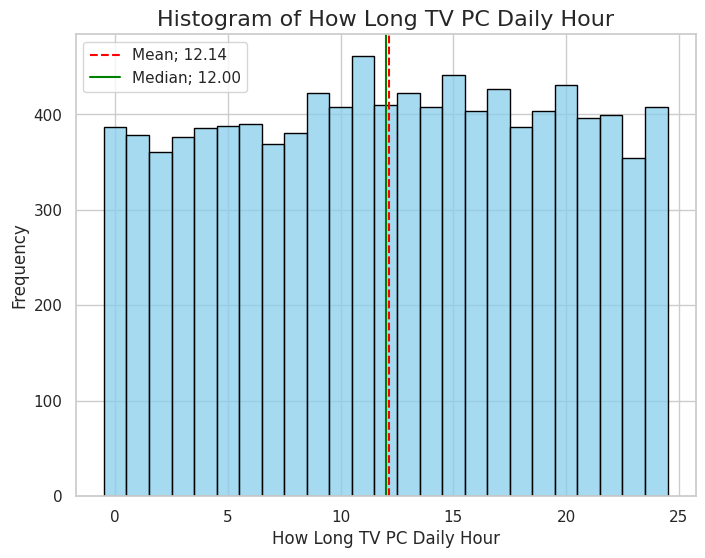

In [62]:
mean=column_dict['How Long TV PC Daily Hour']['mean']
median=column_dict['How Long TV PC Daily Hour']['median']

histogram_sns('How Long TV PC Daily Hour',dataset_encoded,mean,median)

/tmp/ipykernel_31624/1768541527.py:61: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



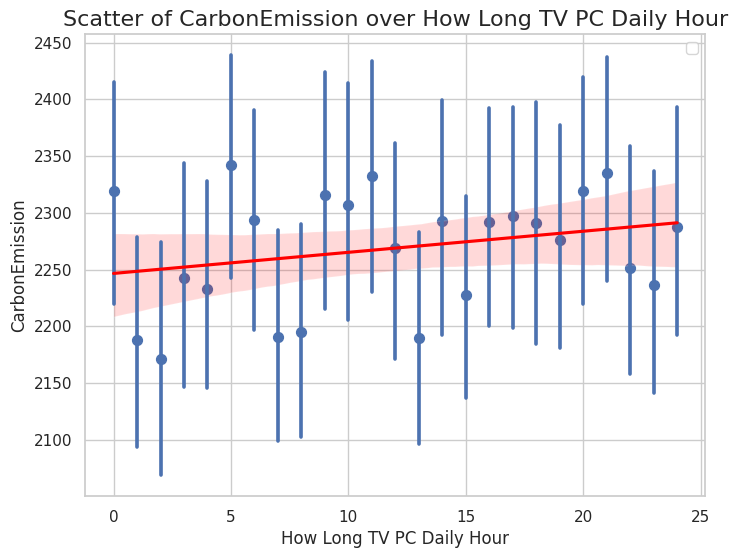

In [63]:
scatter_sns(dataset_encoded,'How Long TV PC Daily Hour', 'CarbonEmission',estimator=np.mean,robust=False)

In [64]:
df_corr=dataset_encoded.corr()['How Long TV PC Daily Hour']
display(df_corr.sort_values(ascending=False,key=lambda x: np.abs(x)))

How Long TV PC Daily Hour        1.000000
Stove                           -0.019694
walk/bicycle                     0.019005
petrol                          -0.016307
CarbonEmission                   0.012985
Paper                            0.012924
electric                        -0.012847
coal                            -0.012384
vegan                            0.011816
Waste Bag Weekly Count          -0.011640
Monthly Grocery Bill            -0.010318
public                          -0.010136
Glass                            0.010102
vegetarian                      -0.010003
How Many New Clothes Monthly     0.009414
Plastic                          0.009243
private                         -0.009066
diesel                           0.008182
Frequency of Traveling by Air   -0.007707
Grill                            0.007687
Airfryer                         0.007687
natural gas                      0.007555
Microwave                       -0.006901
How Long Internet Daily Hour     0

### How Many New Clothes Monthly

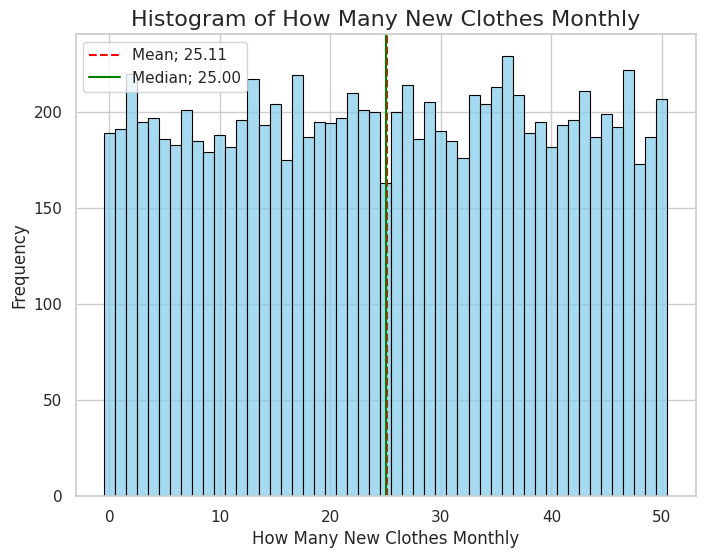

In [65]:
mean=column_dict['How Many New Clothes Monthly']['mean']
median=column_dict['How Many New Clothes Monthly']['median']

histogram_sns('How Many New Clothes Monthly',dataset_encoded,mean,median)

/tmp/ipykernel_31624/1768541527.py:61: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



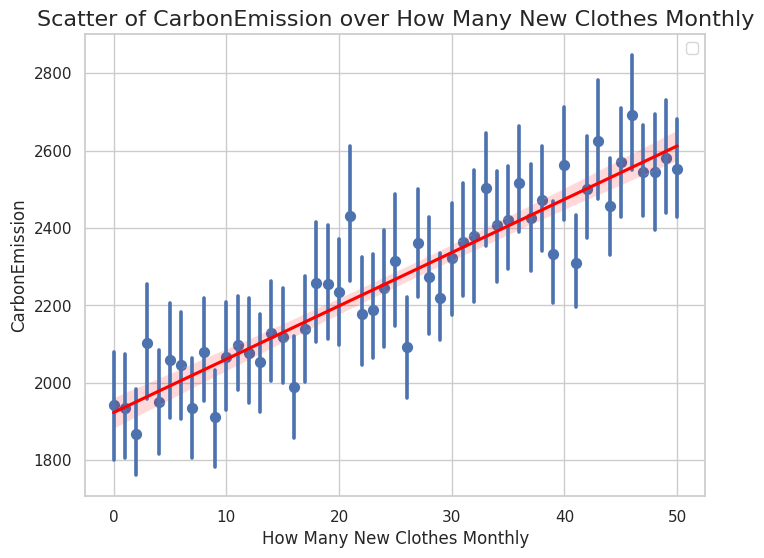

In [66]:
scatter_sns(dataset_encoded,'How Many New Clothes Monthly', 'CarbonEmission',estimator=np.mean,robust=False)

In [67]:
df_corr=dataset_encoded.corr()['How Many New Clothes Monthly']
display(df_corr.sort_values(ascending=False,key=lambda x: np.abs(x)))

How Many New Clothes Monthly     1.000000
CarbonEmission                   0.198887
natural gas                     -0.021232
wood                             0.016526
How Often Shower                 0.014920
Metal                           -0.014698
Stove                            0.014200
Social Activity                 -0.012831
Glass                           -0.010501
How Long TV PC Daily Hour        0.009414
walk/bicycle                    -0.008136
Monthly Grocery Bill             0.006746
How Long Internet Daily Hour     0.006426
vegan                            0.006190
diesel                           0.005612
omnivore                        -0.005311
Plastic                         -0.005003
Vehicle Monthly Distance Km      0.004934
public                           0.004429
Energy efficiency                0.004205
petrol                          -0.003914
Waste Bag Size                  -0.003841
private                          0.003791
Waste Bag Weekly Count          -0

### How Long Internet Daily Hour

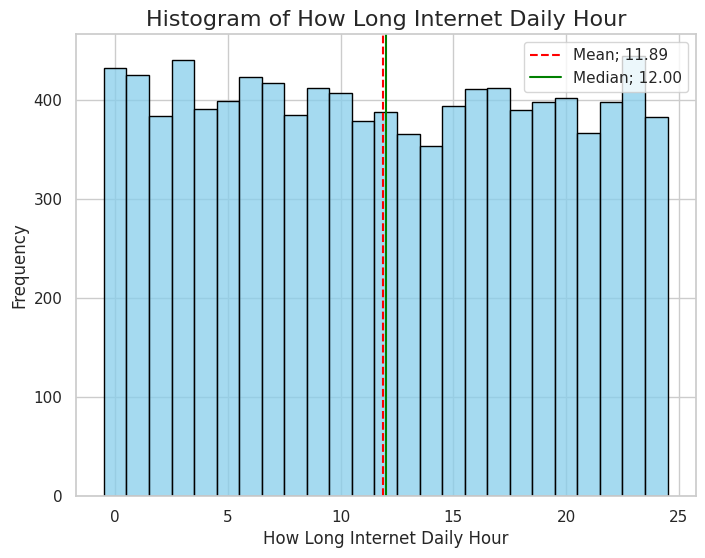

In [68]:
mean=column_dict['How Long Internet Daily Hour']['mean']
median=column_dict['How Long Internet Daily Hour']['median']

histogram_sns('How Long Internet Daily Hour',dataset_encoded,mean,median)

/tmp/ipykernel_31624/1768541527.py:61: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



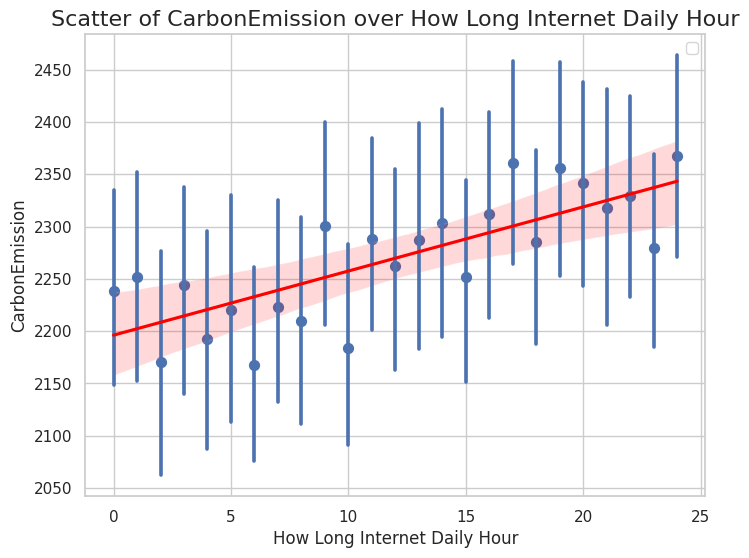

In [69]:
scatter_sns(dataset_encoded,'How Long Internet Daily Hour', 'CarbonEmission',estimator=np.mean,robust=False)

In [70]:
df_corr=dataset_encoded.corr()['How Long Internet Daily Hour']
display(df_corr.sort_values(ascending=False,key=lambda x: np.abs(x)))

How Long Internet Daily Hour     1.000000
CarbonEmission                   0.043878
vegetarian                      -0.023064
Microwave                        0.018790
pescatarian                      0.018758
How Often Shower                 0.015847
Social Activity                  0.015826
Monthly Grocery Bill             0.012798
Energy efficiency               -0.012501
electricity                     -0.012450
petrol                          -0.011689
coal                             0.011637
Glass                            0.009130
Frequency of Traveling by Air   -0.008512
Stove                           -0.008409
diesel                           0.007794
vegan                            0.007300
Metal                            0.007001
hybrid                           0.006851
How Long TV PC Daily Hour        0.006804
How Many New Clothes Monthly     0.006426
Waste Bag Weekly Count          -0.005335
Waste Bag Size                  -0.005056
walk/bicycle                     0

<Figure size 1900x1500 with 0 Axes>

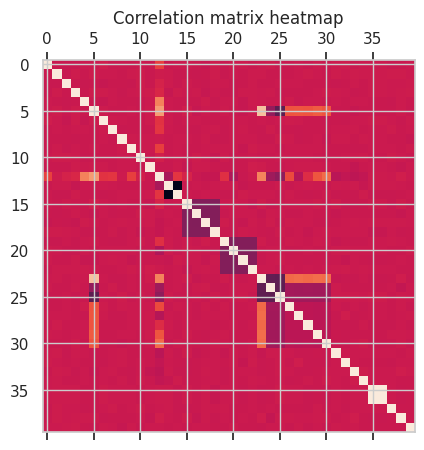

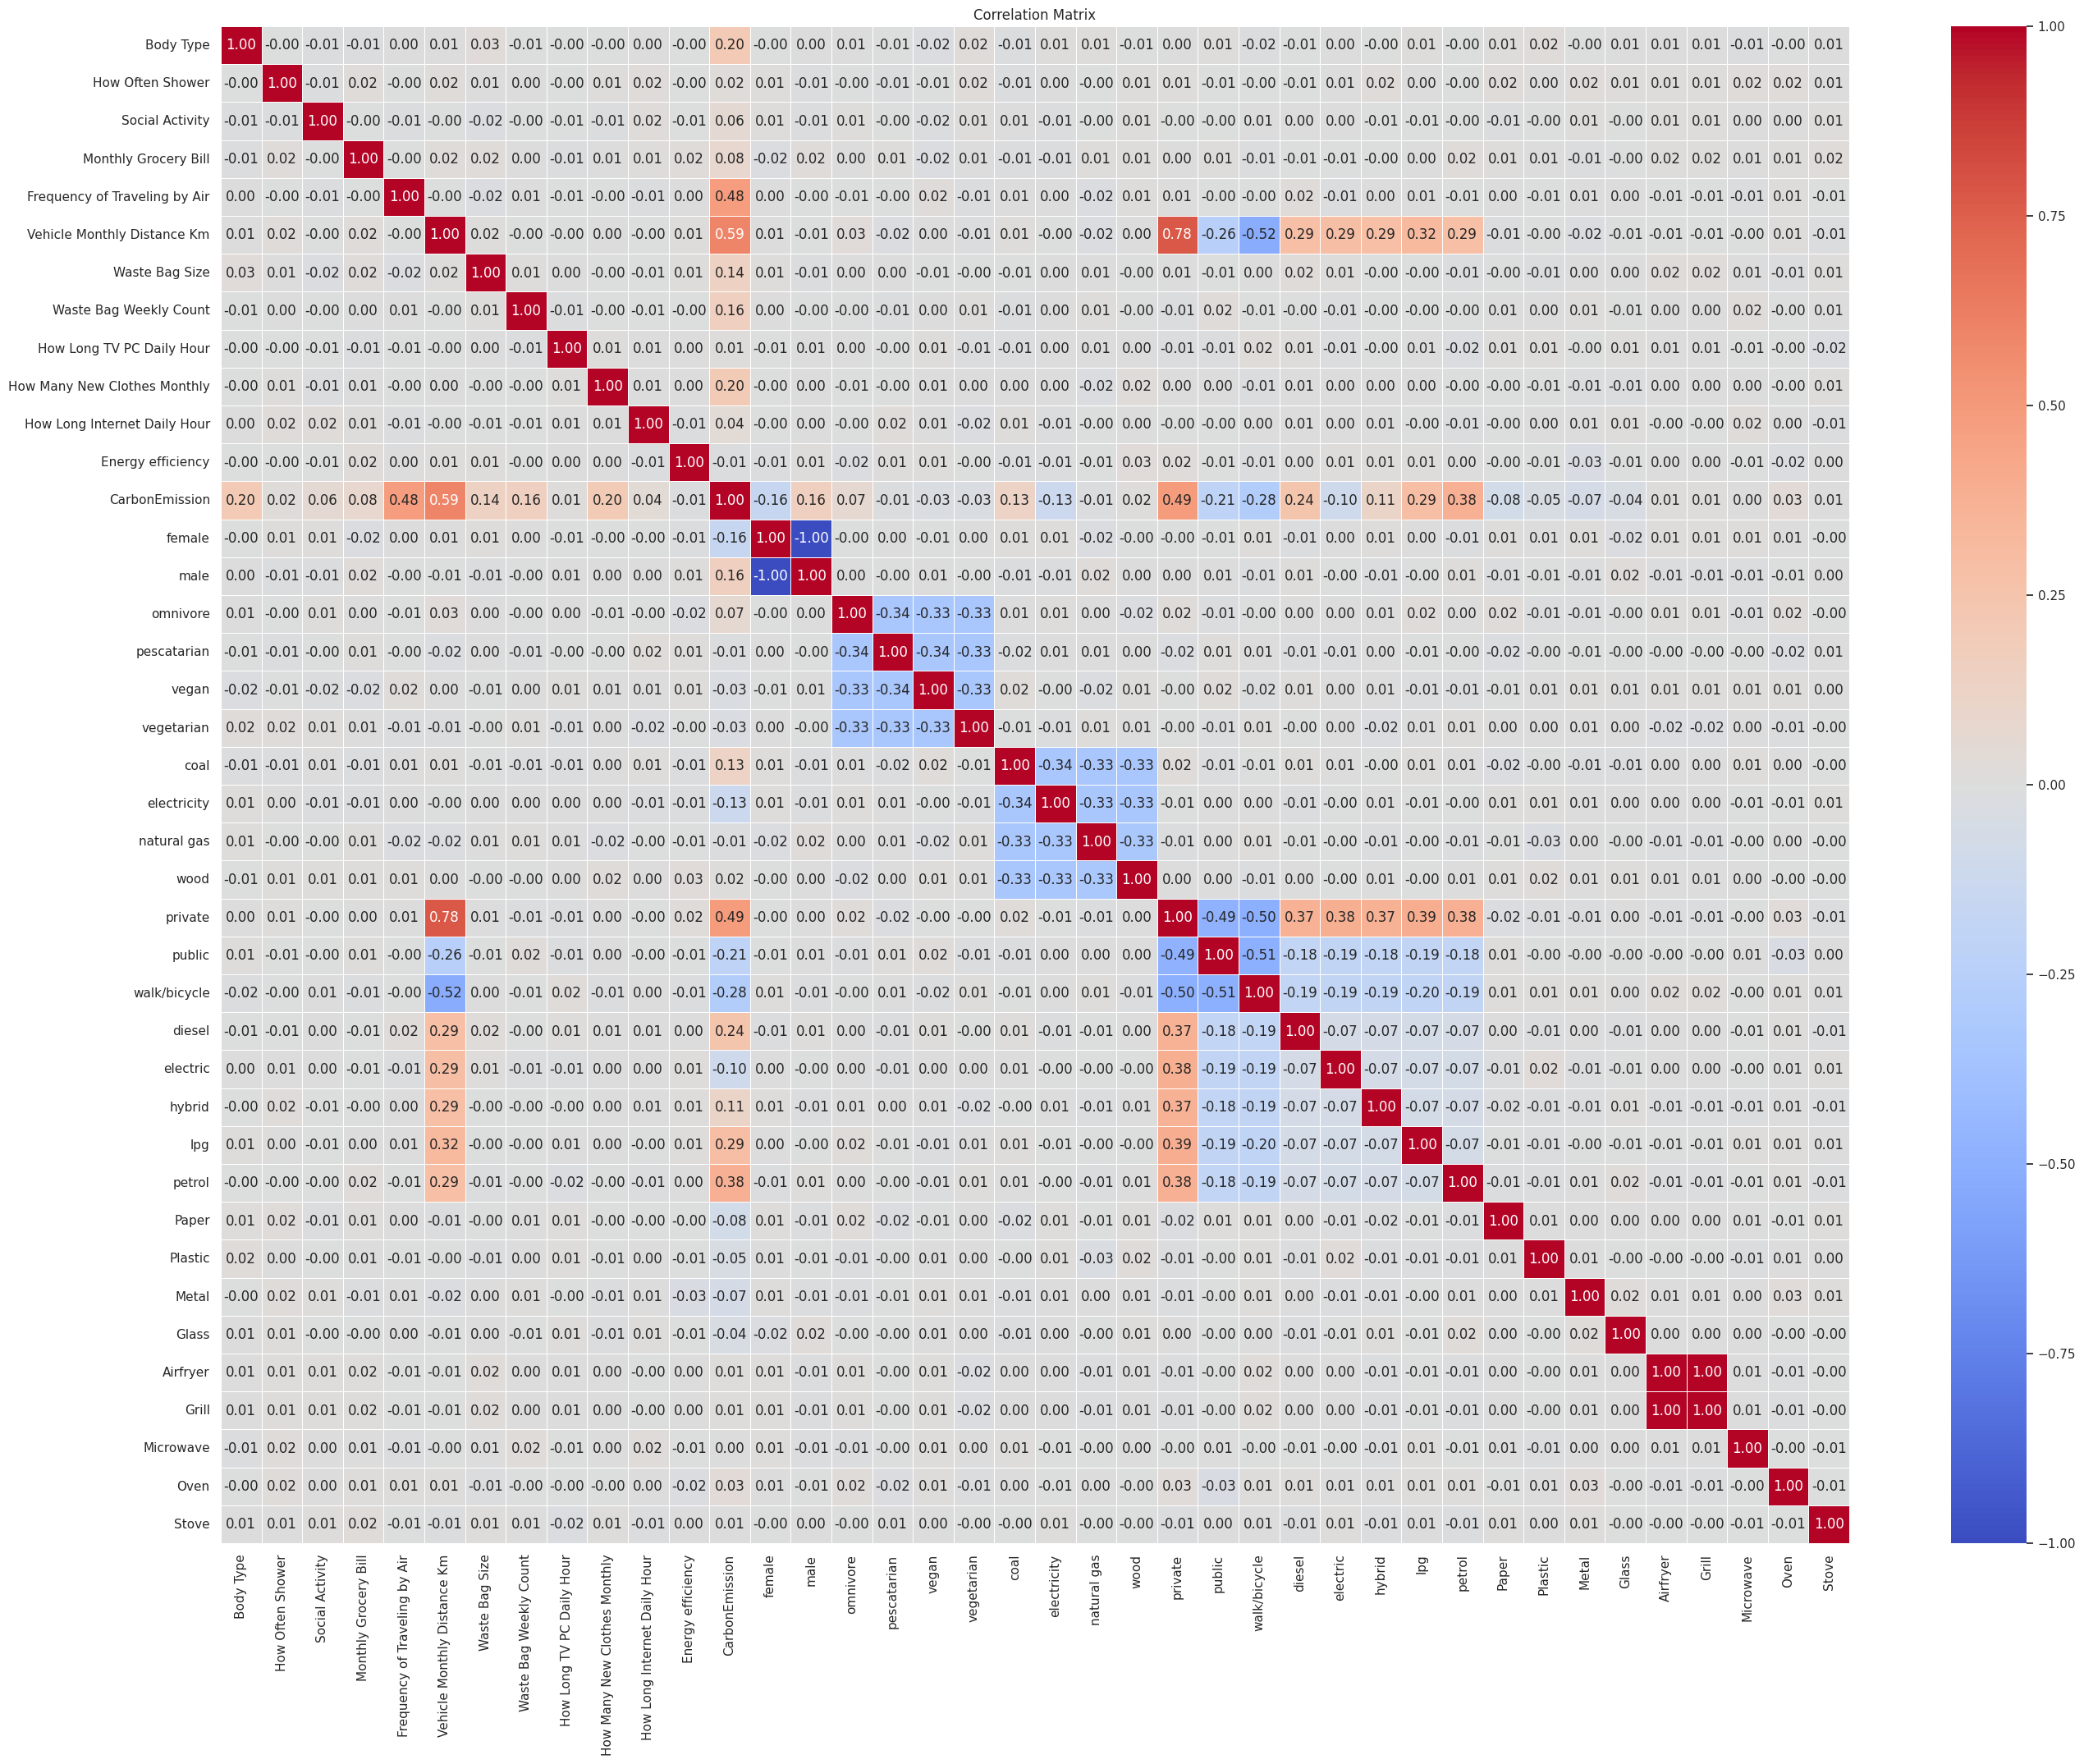

In [71]:
corr_matrix=dataset_encoded.corr()
f=plt.figure(figsize=(19,15))
plt.matshow(corr_matrix)
plt.title("Correlation matrix heatmap")

plt.figure(figsize=(32, 24))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# Funkcije evaluacije

In [72]:
def dataset_split(dataset, target_column_name, train_percent=0.8):
    Y=dataset[target_column_name]
    X=dataset.drop([target_column_name],axis=1)
    X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=1-train_percent)
    return X_train, X_test, Y_train, Y_test

def evaluate_model(X_test, Y_test, model):
    prediction=model.predict(X_test)
    nmse= -mean_squared_error(Y_test,prediction)
    nrmse=-np.sqrt(-nmse)
    r2=r2_score(Y_test,prediction)
    rel_score=-relative_error(Y_test,predicted_value=prediction)
    return [r2,nrmse, nmse,rel_score]

def relative_error(true_value,predicted_value):
    true_value=np.array(true_value)
    predicted_value=np.array(predicted_value)
    non_zero_mask=true_value!=0
    return np.mean(np.abs(true_value[non_zero_mask]-predicted_value[non_zero_mask])/true_value[non_zero_mask]*100)

def cross_validate(model, X_train, Y_train, cv=10, scoring=None):
    score=[]
    if scoring != None:
        score.append(cross_val_score(model,X_train,Y_train, cv=cv, n_jobs=1, scoring=scoring).mean())
    else:
        r2=cross_val_score(model, X_train,Y_train,cv=cv, n_jobs=1, scoring='r2')
        r2=r2.mean()
        nmse=cross_val_score(model, X_train,Y_train,cv=cv, n_jobs=1, scoring='neg_mean_squared_error')
        nmse=nmse.mean()
        nrmse=-np.sqrt(-nmse)
        rel_error_scorer=make_scorer(relative_error,greater_is_better=False)
        rel_error=cross_val_score(model,X_train,Y_train,cv=cv,n_jobs=1,scoring=rel_error_scorer)
        rel_error=rel_error.mean()
        score.append([r2,nrmse,nmse,rel_error])

    return score

def plot_performances(model_names,test_scores=[],cv_scores=[]):
    cv_scores=np.squeeze(np.array(cv_scores))
    test_scores=np.squeeze(np.array(test_scores))
    r2_df = pd.DataFrame({
        'Model': model_names+model_names,
        'Score': np.append(cv_scores[:,0],test_scores[:,0]),
        'Type': ['Cross-Validation'] * len(cv_scores) + ['Test'] * len(test_scores)
    })

    nrmse_df = pd.DataFrame({
        'Model': model_names+model_names,
        'Score': np.append(cv_scores[:,1],test_scores[:,1]),
        'Type': ['Cross-Validation'] * len(model_names) + ['Test'] * len(model_names)
    })

    nmse_df = pd.DataFrame({
        'Model': model_names+model_names,
        'Score': np.append(cv_scores[:,2],test_scores[:,2]),
        'Type': ['Cross-Validation'] * len(model_names) + ['Test'] * len(model_names)
    })

    rel_df = pd.DataFrame({
        'Model': model_names+model_names,
        'Score': np.append(cv_scores[:,3],test_scores[:,3]),
        'Type': ['Cross-Validation'] * len(model_names) + ['Test'] * len(model_names)
    })

    fig,axes=plt.subplots(2,2, figsize=(16,12))
    fig.suptitle(f'Model performance: Cross-Validation vs Test Scores', fontsize=18, y=1.02)
    dfs=[r2_df, nrmse_df,nmse_df,rel_df]
    titles=['R² Scores','NRMSE Scores', 'NMSE Scores','Relative Error Scores']

    for ax,df,title in zip(axes.flat, dfs,titles):
        sns.scatterplot(data=df,x='Model',y='Score',hue='Type',palette='coolwarm',ax=ax)
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('Model',fontsize=12)
        ax.set_ylabel('Score', fontsize=12)
        ax.tick_params(axis='x', rotation=45)
        ax.legend(title='Score Type', loc='lower right', fontsize=10)

    plt.tight_layout()
    plt.show()


def compare_models(models_test_scores, models_cv_scores, model_names, run_names):
    assert model_names!=[] and run_names!=[]
    best={}
    for i,m in enumerate(model_names):
        best_run_test=0
        best_run_cv=0
        for j,run_name in enumerate(run_names):
            if models_test_scores[best_run_test][i]<=models_test_scores[j][i]:
                best_run_test=j
            if models_cv_scores[best_run_cv][i]<=models_cv_scores[j][i]:
                best_run_cv=j
        
        best[m]=f'Best run for model {m} by cv_score is {run_names[best_run_cv]} and by test_score is {run_names[best_run_test]}'
    
    return best

# Train funkcija

In [73]:
def fit_models(models_list,X_train,Y_train,X_test,Y_test):
    cv_scores=[]
    test_scores=[]
    for m in tqdm(models_list):
        cv_scores.append(cross_validate(m,X_train,Y_train,cv=10))
        m.fit(X_train,Y_train)
        test_scores.append(evaluate_model(X_test,Y_test,m))
    return cv_scores,test_scores

# Baseline Modeli

In [74]:
linear=LinearRegression(n_jobs=-1)
ridge=Ridge(random_state=SEED)
lasso=Lasso(random_state=SEED)
elnt=ElasticNet(random_state=SEED)
dt=DecisionTreeRegressor(random_state=SEED)
svr=SVR()
nusvr=NuSVR()
knn=KNeighborsRegressor(n_jobs=-1,)
rf=RandomForestRegressor(n_jobs=-1,random_state=SEED)
gb=GradientBoostingRegressor(random_state=SEED)
xgb=XGBRegressor(random_state = SEED, n_jobs = -1)
lgb=LGBMRegressor(random_state=SEED,n_jobs=-1)
models=[linear,ridge,lasso,elnt,dt,svr,nusvr,knn,rf,gb,xgb,lgb]

model_names = ['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'DecisionTree', 
               'SVR', 'NuSVR', 'KNN', 'RandomForest','GradientBoost', 'XGBoost', 'LightGBM']

 92%|█████████▏| 11/12 [02:30<00:18, 18.00s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2277.357222
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2279.906250
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM]

100%|██████████| 12/12 [02:41<00:00, 13.44s/it]


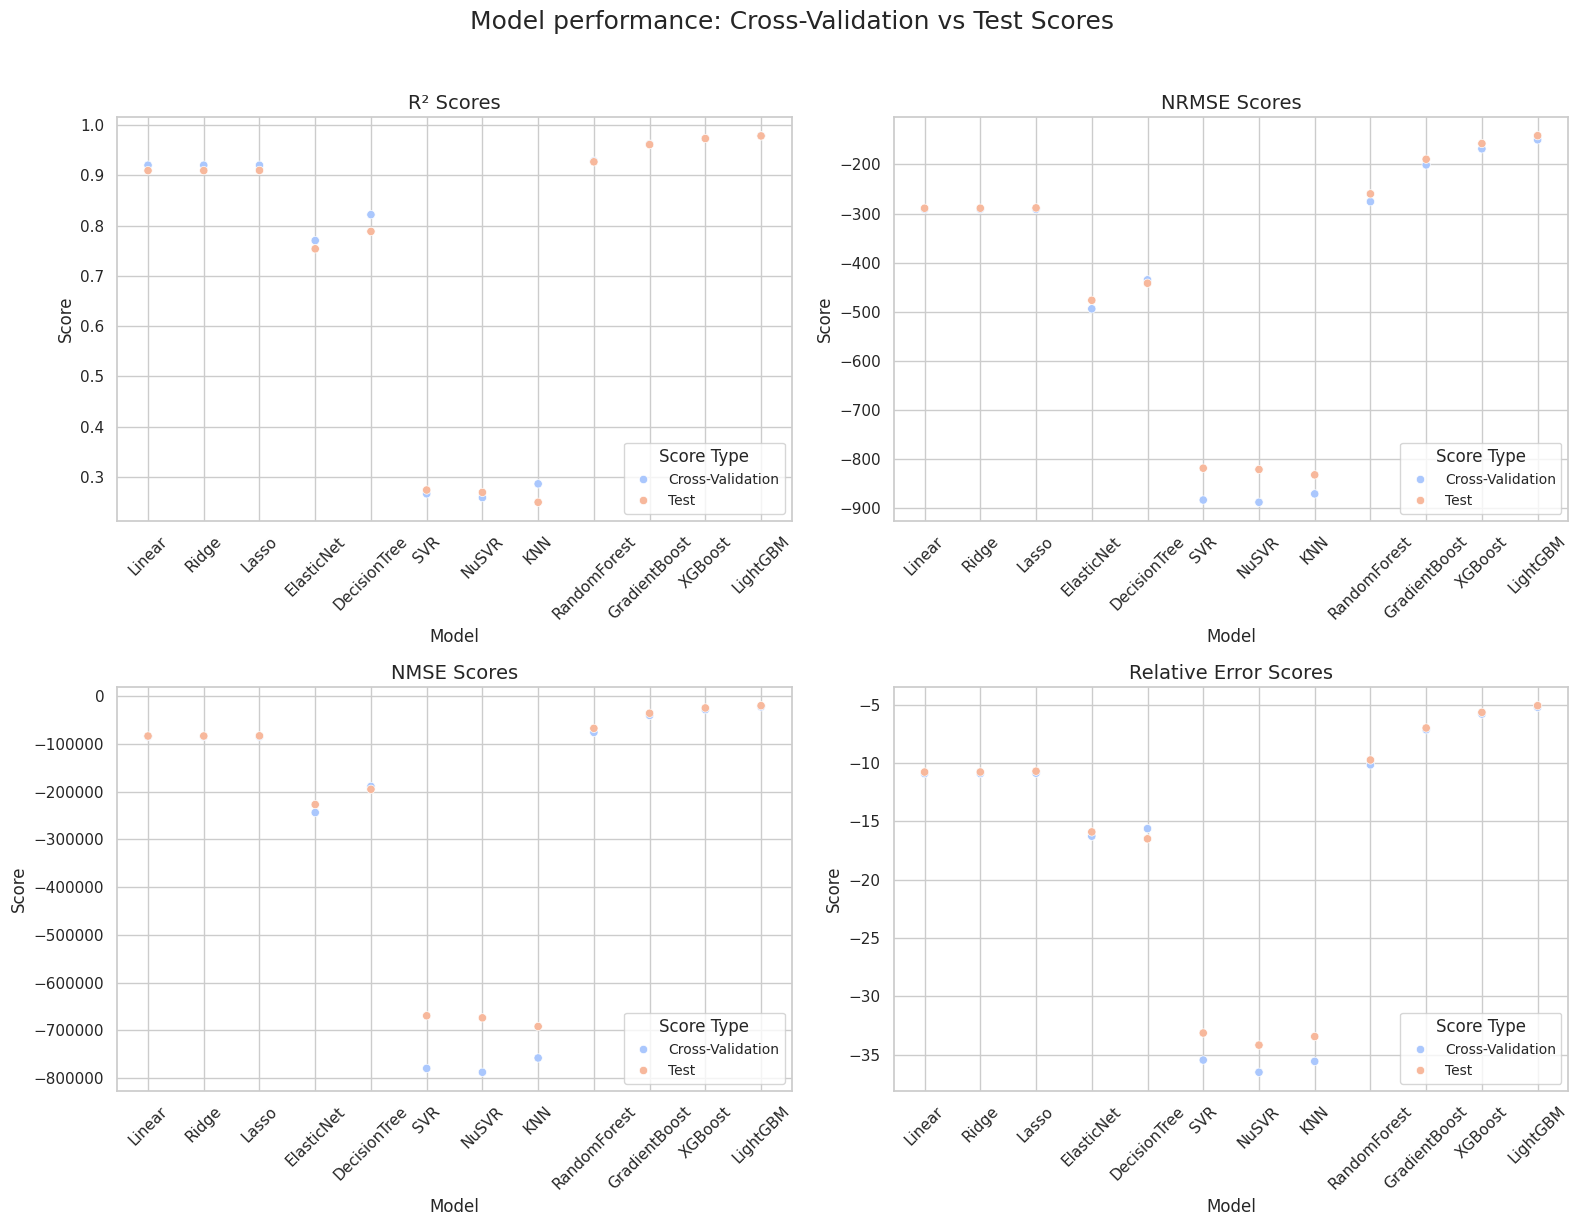

In [75]:
baseline_cv_scores=[]
baseline_test_scores=[]
X_train, X_test, Y_train, Y_test=dataset_split(dataset_encoded,'CarbonEmission',0.8)
baseline_cv_scores,baseline_test_scores=fit_models(models,X_train,Y_train,X_test,Y_test)
plot_performances(model_names=model_names,test_scores=baseline_test_scores,cv_scores=baseline_cv_scores)


# Data preprocessing

Cilj je upoređivanje performansi modela za različite kombainacije data preprocessing-a.

Kreiraju se sve moguće kombinacije izborom po jednog tipa preprocessing-a iz svake od sledećih grupa:

    - Normalizacija [none, MinMaxScaler, StandardScaler, RobustScaler]
    - Tail dominant [none, log, sqrt, box-cox, clipping(winsorization), binning]
    - Feature engineering [none, trashbag size i num of trashbags weekly combined]

In [76]:
def normalize(column:pd.Series, type='rescale'):
    if type=='standard':
        scaler=StandardScaler()
        return scaler.fit_transform(pd.DataFrame(column))
    if type=='robust':
        robust_scaler=RobustScaler()
        return robust_scaler.fit_transform(pd.DataFrame(column))
    if type=='minmax':
        scaler = MinMaxScaler(feature_range=(0,1))
        return scaler.fit_transform(pd.DataFrame(column))
    
def normalize_columns(dataset, columns:list[str], methods=None, include:bool=True):
    temp_columns=[]
    if not include:
        for col in dataset.columns:
            if col not in columns:
                temp_columns.append(col)
        columns=temp_columns
    new_dataset=dataset.copy(deep=True)
    if methods==None:
        methods=['minmax']*len(columns)
    for column, method in zip(columns, methods):
        new_dataset[column] =normalize(new_dataset[column],method)
    return new_dataset


def log_transform(dataset,column_names:list[str]):
    for col in column_names:
        dataset[col]=dataset[col].apply(lambda x:np.log(x) if x>1 else x)
    return dataset

def sqrt_transform(dataset,column_names:list[str]):
    for col in column_names:
        dataset[col]=np.sqrt(dataset[col])
    return dataset

def boxcox_transform(dataset,column_names:list[str]):
    for col in column_names:
        dataset[col]=dataset[col].apply(lambda x:0.1 if x<=0 else x)
        dataset[col],lmbda=boxcox(dataset[col])

    return dataset

def clipping_transform(dataset,column_names:list[str]):
    for col in column_names:
        lower=dataset[col].quantile(0.01)
        upper=dataset[col].quantile(0.99)
        dataset[col]=dataset[col].clip(lower=lower,upper=upper)
    return dataset

def binning_transform(dataset,column_names:list[str]):
    for col in column_names:
        temp=pd.qcut(dataset[col],q=50)
        midpoints=temp.cat.categories.mid
        interval_to_avg={interval:midpoint for interval, midpoint in zip(temp.cat.categories,midpoints)}
        dataset[col]=temp.map(interval_to_avg).astype(float)
    return dataset

def waste_combine(row):
    return row["Waste Bag Size"]*row["Waste Bag Weekly Count"]

In [77]:
models=[linear,ridge,lasso,elnt,dt,knn,rf,gb,xgb,lgb,svr,nusvr]
model_names = ['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'DecisionTree','KNN', 'RandomForest','GradientBoost', 'XGBoost', 'LightGBM','SVR','NuSVR']
feature_engineering=[None,"trashbag_size and num_trashbags combines"]
tail=[None,"log","sqrt","boxcox","clipping","binning"]
tail_functions=[None,log_transform,sqrt_transform,boxcox_transform,clipping_transform,binning_transform]

normalizations=[None,"minmax", "robust","standard"]


In [78]:
X_train_org, X_test_org, Y_train, Y_test=dataset_split(dataset_encoded,'CarbonEmission',0.8)

In [ ]:
results_file='results_final.csv'
with open(results_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([
        "Model", "FeatureEngineering", "Transform", "Normalization",
        "Test_R2", "Test_NRMSE", "Test_NMSE", "Test_Rel",
        "CV_R2", "CV_NRMSE", "CV_NMSE", "CV_Rel"
    ])

results=np.zeros((len(models),len(feature_engineering),len(tail_functions),len(normalizations),2,4))
print(results.size)
try:
    for model_idx,(model, model_name) in enumerate(zip(models,model_names)):
        X_train=X_train_org.copy()
        X_test=X_test_org.copy()
        for fe_idx,fe in enumerate(feature_engineering):
            X_train_fe=X_train.copy()
            X_test_fe=X_test.copy()
            if fe is not None:
                X_train_fe["Waste"]=X_train_fe.apply(waste_combine,axis=1)
                X_train_fe=X_train_fe.drop("Waste Bag Size",axis=1)
                X_train_fe=X_train_fe.drop("Waste Bag Weekly Count",axis=1)
                X_test_fe["Waste"]=X_test_fe.apply(waste_combine,axis=1)
                X_test_fe=X_test_fe.drop("Waste Bag Size",axis=1)
                X_test_fe=X_test_fe.drop("Waste Bag Weekly Count",axis=1)
            for transform_idx,(transform, transfrom_name) in enumerate(zip(tail_functions,tail)):
                X_train_fe_tr=X_train_fe.copy()
                X_test_fe_tr=X_test_fe.copy()
                if transform is not None:
                    X_train_fe_tr=transform(X_train_fe_tr,['Vehicle Monthly Distance Km'])
                    X_test_fe_tr=transform(X_test_fe_tr,['Vehicle Monthly Distance Km'])
                for norm_idx,norm in enumerate(normalizations):
                    X_train_fe_tr_norm=X_train_fe_tr.copy()
                    X_test_fe_tr_norm=X_test_fe_tr.copy()
                    if norm is not None:
                        X_train_fe_tr_norm=normalize_columns(X_train_fe_tr_norm,methods=[norm]*(X_train_fe_tr_norm.shape[1]),columns=[],include=False)
                        X_test_fe_tr_norm=normalize_columns(X_test_fe_tr_norm,methods=[norm]*(X_test_fe_tr_norm.shape[1]),columns=[],include=False)
                    
                    test_score,cv_score=fit_models([model],X_train_fe_tr_norm,Y_train,X_test_fe_tr_norm,Y_test)
                    results[model_idx,fe_idx,transform_idx,norm_idx,0,:]=np.array(test_score)
                    results[model_idx,fe_idx,transform_idx,norm_idx,1,:]=np.array(cv_score)
                    print(f"{model_name}:{fe}:{transfrom_name}:{norm}")
                    with open(results_file,'a') as f:
                        writer=csv.writer(f)
                        writer.writerow([
                            model_name,fe if fe is not None else "None", 
                            transfrom_name if transfrom_name is not None else "None",
                            norm if norm is not None else "None",
                            *np.array(test_score).squeeze(),
                            *np.array(cv_score).squeeze()
                        ])
except Exception as e:
    print(e)
    print(results)



4608


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Linear:None:None:None


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Linear:None:None:minmax


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Linear:None:None:robust


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Linear:None:None:standard


100%|██████████| 1/1 [00:00<00:00,  4.38it/s]


Linear:None:log:None


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Linear:None:log:minmax


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


Linear:None:log:robust


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Linear:None:log:standard


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Linear:None:sqrt:None


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Linear:None:sqrt:minmax


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


Linear:None:sqrt:robust


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Linear:None:sqrt:standard


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Linear:None:boxcox:None


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Linear:None:boxcox:minmax


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


Linear:None:boxcox:robust


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Linear:None:boxcox:standard


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


Linear:None:clipping:None


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


Linear:None:clipping:minmax


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Linear:None:clipping:robust


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Linear:None:clipping:standard


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Linear:None:binning:None


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Linear:None:binning:minmax


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Linear:None:binning:robust


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Linear:None:binning:standard


100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


Linear:trashbag_size and num_trashbags combines:None:None


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Linear:trashbag_size and num_trashbags combines:None:minmax


100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Linear:trashbag_size and num_trashbags combines:None:robust


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Linear:trashbag_size and num_trashbags combines:None:standard


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


Linear:trashbag_size and num_trashbags combines:log:None


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Linear:trashbag_size and num_trashbags combines:log:minmax


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Linear:trashbag_size and num_trashbags combines:log:robust


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Linear:trashbag_size and num_trashbags combines:log:standard


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


Linear:trashbag_size and num_trashbags combines:sqrt:None


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Linear:trashbag_size and num_trashbags combines:sqrt:minmax


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Linear:trashbag_size and num_trashbags combines:sqrt:robust


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Linear:trashbag_size and num_trashbags combines:sqrt:standard


100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Linear:trashbag_size and num_trashbags combines:boxcox:None


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Linear:trashbag_size and num_trashbags combines:boxcox:minmax


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Linear:trashbag_size and num_trashbags combines:boxcox:robust


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Linear:trashbag_size and num_trashbags combines:boxcox:standard


100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


Linear:trashbag_size and num_trashbags combines:clipping:None


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Linear:trashbag_size and num_trashbags combines:clipping:minmax


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Linear:trashbag_size and num_trashbags combines:clipping:robust


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Linear:trashbag_size and num_trashbags combines:clipping:standard


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Linear:trashbag_size and num_trashbags combines:binning:None


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Linear:trashbag_size and num_trashbags combines:binning:minmax


100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


Linear:trashbag_size and num_trashbags combines:binning:robust


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Linear:trashbag_size and num_trashbags combines:binning:standard


100%|██████████| 1/1 [00:00<00:00,  6.72it/s]


Ridge:None:None:None


100%|██████████| 1/1 [00:00<00:00,  6.86it/s]


Ridge:None:None:minmax


100%|██████████| 1/1 [00:00<00:00,  6.50it/s]


Ridge:None:None:robust


100%|██████████| 1/1 [00:00<00:00,  6.08it/s]


Ridge:None:None:standard


100%|██████████| 1/1 [00:00<00:00,  7.65it/s]


Ridge:None:log:None


100%|██████████| 1/1 [00:00<00:00,  6.51it/s]


Ridge:None:log:minmax


100%|██████████| 1/1 [00:00<00:00,  6.74it/s]


Ridge:None:log:robust


100%|██████████| 1/1 [00:00<00:00,  6.75it/s]


Ridge:None:log:standard


100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


Ridge:None:sqrt:None


100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


Ridge:None:sqrt:minmax


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


Ridge:None:sqrt:robust


100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


Ridge:None:sqrt:standard


100%|██████████| 1/1 [00:00<00:00,  7.54it/s]


Ridge:None:boxcox:None


100%|██████████| 1/1 [00:00<00:00,  6.65it/s]


Ridge:None:boxcox:minmax


100%|██████████| 1/1 [00:00<00:00,  6.51it/s]


Ridge:None:boxcox:robust


100%|██████████| 1/1 [00:00<00:00,  6.35it/s]


Ridge:None:boxcox:standard


100%|██████████| 1/1 [00:00<00:00,  6.79it/s]


Ridge:None:clipping:None


100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


Ridge:None:clipping:minmax


100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


Ridge:None:clipping:robust


100%|██████████| 1/1 [00:00<00:00,  6.26it/s]


Ridge:None:clipping:standard


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


Ridge:None:binning:None


100%|██████████| 1/1 [00:00<00:00,  6.69it/s]


Ridge:None:binning:minmax


100%|██████████| 1/1 [00:00<00:00,  6.34it/s]


Ridge:None:binning:robust


100%|██████████| 1/1 [00:00<00:00,  6.89it/s]


Ridge:None:binning:standard


100%|██████████| 1/1 [00:00<00:00,  7.33it/s]


Ridge:trashbag_size and num_trashbags combines:None:None


100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


Ridge:trashbag_size and num_trashbags combines:None:minmax


100%|██████████| 1/1 [00:00<00:00,  6.88it/s]


Ridge:trashbag_size and num_trashbags combines:None:robust


100%|██████████| 1/1 [00:00<00:00,  7.09it/s]


Ridge:trashbag_size and num_trashbags combines:None:standard


100%|██████████| 1/1 [00:00<00:00,  7.56it/s]


Ridge:trashbag_size and num_trashbags combines:log:None


100%|██████████| 1/1 [00:00<00:00,  6.99it/s]


Ridge:trashbag_size and num_trashbags combines:log:minmax


100%|██████████| 1/1 [00:00<00:00,  6.45it/s]


Ridge:trashbag_size and num_trashbags combines:log:robust


100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


Ridge:trashbag_size and num_trashbags combines:log:standard


100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


Ridge:trashbag_size and num_trashbags combines:sqrt:None


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


Ridge:trashbag_size and num_trashbags combines:sqrt:minmax


100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


Ridge:trashbag_size and num_trashbags combines:sqrt:robust


100%|██████████| 1/1 [00:00<00:00,  6.16it/s]


Ridge:trashbag_size and num_trashbags combines:sqrt:standard


100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


Ridge:trashbag_size and num_trashbags combines:boxcox:None


100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


Ridge:trashbag_size and num_trashbags combines:boxcox:minmax


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


Ridge:trashbag_size and num_trashbags combines:boxcox:robust


100%|██████████| 1/1 [00:00<00:00,  7.10it/s]


Ridge:trashbag_size and num_trashbags combines:boxcox:standard


100%|██████████| 1/1 [00:00<00:00,  8.14it/s]


Ridge:trashbag_size and num_trashbags combines:clipping:None


100%|██████████| 1/1 [00:00<00:00,  7.10it/s]


Ridge:trashbag_size and num_trashbags combines:clipping:minmax


100%|██████████| 1/1 [00:00<00:00,  7.09it/s]


Ridge:trashbag_size and num_trashbags combines:clipping:robust


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


Ridge:trashbag_size and num_trashbags combines:clipping:standard


100%|██████████| 1/1 [00:00<00:00,  8.24it/s]


Ridge:trashbag_size and num_trashbags combines:binning:None


100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


Ridge:trashbag_size and num_trashbags combines:binning:minmax


100%|██████████| 1/1 [00:00<00:00,  7.04it/s]


Ridge:trashbag_size and num_trashbags combines:binning:robust


100%|██████████| 1/1 [00:00<00:00,  7.01it/s]


Ridge:trashbag_size and num_trashbags combines:binning:standard


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Lasso:None:None:None


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


Lasso:None:None:minmax


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


Lasso:None:None:robust


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Lasso:None:None:standard


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


Lasso:None:log:None


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Lasso:None:log:minmax


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


Lasso:None:log:robust


100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


Lasso:None:log:standard


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Lasso:None:sqrt:None


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Lasso:None:sqrt:minmax


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Lasso:None:sqrt:robust


100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Lasso:None:sqrt:standard


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Lasso:None:boxcox:None


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


Lasso:None:boxcox:minmax


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


Lasso:None:boxcox:robust


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Lasso:None:boxcox:standard


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Lasso:None:clipping:None


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Lasso:None:clipping:minmax


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


Lasso:None:clipping:robust


100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Lasso:None:clipping:standard


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Lasso:None:binning:None


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


Lasso:None:binning:minmax


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Lasso:None:binning:robust


100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Lasso:None:binning:standard


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


Lasso:trashbag_size and num_trashbags combines:None:None


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


Lasso:trashbag_size and num_trashbags combines:None:minmax


100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


Lasso:trashbag_size and num_trashbags combines:None:robust


100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


Lasso:trashbag_size and num_trashbags combines:None:standard


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


Lasso:trashbag_size and num_trashbags combines:log:None


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


Lasso:trashbag_size and num_trashbags combines:log:minmax


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


Lasso:trashbag_size and num_trashbags combines:log:robust


100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


Lasso:trashbag_size and num_trashbags combines:log:standard


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Lasso:trashbag_size and num_trashbags combines:sqrt:None


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Lasso:trashbag_size and num_trashbags combines:sqrt:minmax


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Lasso:trashbag_size and num_trashbags combines:sqrt:robust


100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Lasso:trashbag_size and num_trashbags combines:sqrt:standard


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Lasso:trashbag_size and num_trashbags combines:boxcox:None


100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


Lasso:trashbag_size and num_trashbags combines:boxcox:minmax


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Lasso:trashbag_size and num_trashbags combines:boxcox:robust


100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


Lasso:trashbag_size and num_trashbags combines:boxcox:standard


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Lasso:trashbag_size and num_trashbags combines:clipping:None


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Lasso:trashbag_size and num_trashbags combines:clipping:minmax


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Lasso:trashbag_size and num_trashbags combines:clipping:robust


100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Lasso:trashbag_size and num_trashbags combines:clipping:standard


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Lasso:trashbag_size and num_trashbags combines:binning:None


100%|██████████| 1/1 [00:00<00:00,  4.42it/s]


Lasso:trashbag_size and num_trashbags combines:binning:minmax


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Lasso:trashbag_size and num_trashbags combines:binning:robust


100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


Lasso:trashbag_size and num_trashbags combines:binning:standard


100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


ElasticNet:None:None:None


100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


ElasticNet:None:None:minmax


100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


ElasticNet:None:None:robust


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


ElasticNet:None:None:standard


100%|██████████| 1/1 [00:00<00:00,  6.65it/s]


ElasticNet:None:log:None


100%|██████████| 1/1 [00:00<00:00,  6.33it/s]


ElasticNet:None:log:minmax


100%|██████████| 1/1 [00:00<00:00,  6.09it/s]


ElasticNet:None:log:robust


100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


ElasticNet:None:log:standard


100%|██████████| 1/1 [00:00<00:00,  6.76it/s]


ElasticNet:None:sqrt:None


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


ElasticNet:None:sqrt:minmax


100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


ElasticNet:None:sqrt:robust


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


ElasticNet:None:sqrt:standard


100%|██████████| 1/1 [00:00<00:00,  6.55it/s]


ElasticNet:None:boxcox:None


100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


ElasticNet:None:boxcox:minmax


100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


ElasticNet:None:boxcox:robust


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


ElasticNet:None:boxcox:standard


100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


ElasticNet:None:clipping:None


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


ElasticNet:None:clipping:minmax


100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


ElasticNet:None:clipping:robust


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


ElasticNet:None:clipping:standard


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


ElasticNet:None:binning:None


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


ElasticNet:None:binning:minmax


100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


ElasticNet:None:binning:robust


100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


ElasticNet:None:binning:standard


100%|██████████| 1/1 [00:00<00:00,  6.29it/s]


ElasticNet:trashbag_size and num_trashbags combines:None:None


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


ElasticNet:trashbag_size and num_trashbags combines:None:minmax


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


ElasticNet:trashbag_size and num_trashbags combines:None:robust


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


ElasticNet:trashbag_size and num_trashbags combines:None:standard


100%|██████████| 1/1 [00:00<00:00,  6.92it/s]


ElasticNet:trashbag_size and num_trashbags combines:log:None


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


ElasticNet:trashbag_size and num_trashbags combines:log:minmax


100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


ElasticNet:trashbag_size and num_trashbags combines:log:robust


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


ElasticNet:trashbag_size and num_trashbags combines:log:standard


100%|██████████| 1/1 [00:00<00:00,  6.19it/s]


ElasticNet:trashbag_size and num_trashbags combines:sqrt:None


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


ElasticNet:trashbag_size and num_trashbags combines:sqrt:minmax


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


ElasticNet:trashbag_size and num_trashbags combines:sqrt:robust


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


ElasticNet:trashbag_size and num_trashbags combines:sqrt:standard


100%|██████████| 1/1 [00:00<00:00,  6.11it/s]


ElasticNet:trashbag_size and num_trashbags combines:boxcox:None


100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


ElasticNet:trashbag_size and num_trashbags combines:boxcox:minmax


100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


ElasticNet:trashbag_size and num_trashbags combines:boxcox:robust


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


ElasticNet:trashbag_size and num_trashbags combines:boxcox:standard


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


ElasticNet:trashbag_size and num_trashbags combines:clipping:None


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


ElasticNet:trashbag_size and num_trashbags combines:clipping:minmax


100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


ElasticNet:trashbag_size and num_trashbags combines:clipping:robust


100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


ElasticNet:trashbag_size and num_trashbags combines:clipping:standard


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


ElasticNet:trashbag_size and num_trashbags combines:binning:None


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


ElasticNet:trashbag_size and num_trashbags combines:binning:minmax


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


ElasticNet:trashbag_size and num_trashbags combines:binning:robust


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


ElasticNet:trashbag_size and num_trashbags combines:binning:standard


100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


DecisionTree:None:None:None


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


DecisionTree:None:None:minmax


100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


DecisionTree:None:None:robust


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


DecisionTree:None:None:standard


100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


DecisionTree:None:log:None


100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


DecisionTree:None:log:minmax


100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


DecisionTree:None:log:robust


100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


DecisionTree:None:log:standard


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


DecisionTree:None:sqrt:None


100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


DecisionTree:None:sqrt:minmax


100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


DecisionTree:None:sqrt:robust


100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


DecisionTree:None:sqrt:standard


100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


DecisionTree:None:boxcox:None


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


DecisionTree:None:boxcox:minmax


100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


DecisionTree:None:boxcox:robust


100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


DecisionTree:None:boxcox:standard


100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


DecisionTree:None:clipping:None


100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


DecisionTree:None:clipping:minmax


100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


DecisionTree:None:clipping:robust


100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


DecisionTree:None:clipping:standard


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


DecisionTree:None:binning:None


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


DecisionTree:None:binning:minmax


100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


DecisionTree:None:binning:robust


100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


DecisionTree:None:binning:standard


100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


DecisionTree:trashbag_size and num_trashbags combines:None:None


100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


DecisionTree:trashbag_size and num_trashbags combines:None:minmax


100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


DecisionTree:trashbag_size and num_trashbags combines:None:robust


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


DecisionTree:trashbag_size and num_trashbags combines:None:standard


100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


DecisionTree:trashbag_size and num_trashbags combines:log:None


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


DecisionTree:trashbag_size and num_trashbags combines:log:minmax


100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


DecisionTree:trashbag_size and num_trashbags combines:log:robust


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


DecisionTree:trashbag_size and num_trashbags combines:log:standard


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


DecisionTree:trashbag_size and num_trashbags combines:sqrt:None


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


DecisionTree:trashbag_size and num_trashbags combines:sqrt:minmax


100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


DecisionTree:trashbag_size and num_trashbags combines:sqrt:robust


100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


DecisionTree:trashbag_size and num_trashbags combines:sqrt:standard


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


DecisionTree:trashbag_size and num_trashbags combines:boxcox:None


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


DecisionTree:trashbag_size and num_trashbags combines:boxcox:minmax


100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


DecisionTree:trashbag_size and num_trashbags combines:boxcox:robust


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


DecisionTree:trashbag_size and num_trashbags combines:boxcox:standard


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


DecisionTree:trashbag_size and num_trashbags combines:clipping:None


100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


DecisionTree:trashbag_size and num_trashbags combines:clipping:minmax


100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


DecisionTree:trashbag_size and num_trashbags combines:clipping:robust


100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


DecisionTree:trashbag_size and num_trashbags combines:clipping:standard


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


DecisionTree:trashbag_size and num_trashbags combines:binning:None


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


DecisionTree:trashbag_size and num_trashbags combines:binning:minmax


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


DecisionTree:trashbag_size and num_trashbags combines:binning:robust


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


DecisionTree:trashbag_size and num_trashbags combines:binning:standard


100%|██████████| 1/1 [00:03<00:00,  3.89s/it]


KNN:None:None:None


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


KNN:None:None:minmax


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


KNN:None:None:robust


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


KNN:None:None:standard


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


KNN:None:log:None


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


KNN:None:log:minmax


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


KNN:None:log:robust


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


KNN:None:log:standard


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


KNN:None:sqrt:None


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


KNN:None:sqrt:minmax


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


KNN:None:sqrt:robust


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


KNN:None:sqrt:standard


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


KNN:None:boxcox:None


100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


KNN:None:boxcox:minmax


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


KNN:None:boxcox:robust


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


KNN:None:boxcox:standard


100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


KNN:None:clipping:None


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


KNN:None:clipping:minmax


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


KNN:None:clipping:robust


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


KNN:None:clipping:standard


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


KNN:None:binning:None


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


KNN:None:binning:minmax


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


KNN:None:binning:robust


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


KNN:None:binning:standard


100%|██████████| 1/1 [00:04<00:00,  4.31s/it]


KNN:trashbag_size and num_trashbags combines:None:None


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


KNN:trashbag_size and num_trashbags combines:None:minmax


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


KNN:trashbag_size and num_trashbags combines:None:robust


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


KNN:trashbag_size and num_trashbags combines:None:standard


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


KNN:trashbag_size and num_trashbags combines:log:None


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


KNN:trashbag_size and num_trashbags combines:log:minmax


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


KNN:trashbag_size and num_trashbags combines:log:robust


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


KNN:trashbag_size and num_trashbags combines:log:standard


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


KNN:trashbag_size and num_trashbags combines:sqrt:None


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


KNN:trashbag_size and num_trashbags combines:sqrt:minmax


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


KNN:trashbag_size and num_trashbags combines:sqrt:robust


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


KNN:trashbag_size and num_trashbags combines:sqrt:standard


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


KNN:trashbag_size and num_trashbags combines:boxcox:None


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


KNN:trashbag_size and num_trashbags combines:boxcox:minmax


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


KNN:trashbag_size and num_trashbags combines:boxcox:robust


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


KNN:trashbag_size and num_trashbags combines:boxcox:standard


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


KNN:trashbag_size and num_trashbags combines:clipping:None


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


KNN:trashbag_size and num_trashbags combines:clipping:minmax


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


KNN:trashbag_size and num_trashbags combines:clipping:robust


100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


KNN:trashbag_size and num_trashbags combines:clipping:standard


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


KNN:trashbag_size and num_trashbags combines:binning:None


100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


KNN:trashbag_size and num_trashbags combines:binning:minmax


100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


KNN:trashbag_size and num_trashbags combines:binning:robust


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


KNN:trashbag_size and num_trashbags combines:binning:standard


100%|██████████| 1/1 [00:18<00:00, 18.88s/it]


RandomForest:None:None:None


100%|██████████| 1/1 [00:19<00:00, 19.14s/it]


RandomForest:None:None:minmax


100%|██████████| 1/1 [00:19<00:00, 19.71s/it]


RandomForest:None:None:robust


100%|██████████| 1/1 [00:18<00:00, 18.55s/it]


RandomForest:None:None:standard


100%|██████████| 1/1 [00:18<00:00, 18.03s/it]


RandomForest:None:log:None


100%|██████████| 1/1 [00:18<00:00, 18.06s/it]


RandomForest:None:log:minmax


100%|██████████| 1/1 [00:17<00:00, 17.99s/it]


RandomForest:None:log:robust


100%|██████████| 1/1 [00:18<00:00, 18.03s/it]


RandomForest:None:log:standard


100%|██████████| 1/1 [00:17<00:00, 17.96s/it]


RandomForest:None:sqrt:None


100%|██████████| 1/1 [00:18<00:00, 18.02s/it]


RandomForest:None:sqrt:minmax


100%|██████████| 1/1 [00:17<00:00, 17.91s/it]


RandomForest:None:sqrt:robust


100%|██████████| 1/1 [00:18<00:00, 18.09s/it]


RandomForest:None:sqrt:standard


100%|██████████| 1/1 [00:18<00:00, 18.06s/it]


RandomForest:None:boxcox:None


100%|██████████| 1/1 [00:18<00:00, 18.01s/it]


RandomForest:None:boxcox:minmax


100%|██████████| 1/1 [00:17<00:00, 17.97s/it]


RandomForest:None:boxcox:robust


100%|██████████| 1/1 [00:18<00:00, 18.02s/it]


RandomForest:None:boxcox:standard


100%|██████████| 1/1 [00:18<00:00, 18.08s/it]


RandomForest:None:clipping:None


100%|██████████| 1/1 [00:18<00:00, 18.05s/it]


RandomForest:None:clipping:minmax


100%|██████████| 1/1 [00:17<00:00, 17.98s/it]


RandomForest:None:clipping:robust


100%|██████████| 1/1 [00:17<00:00, 17.98s/it]


RandomForest:None:clipping:standard


100%|██████████| 1/1 [00:17<00:00, 17.25s/it]


RandomForest:None:binning:None


100%|██████████| 1/1 [00:17<00:00, 17.14s/it]


RandomForest:None:binning:minmax


100%|██████████| 1/1 [00:17<00:00, 17.20s/it]


RandomForest:None:binning:robust


100%|██████████| 1/1 [00:17<00:00, 17.19s/it]


RandomForest:None:binning:standard


100%|██████████| 1/1 [00:17<00:00, 17.84s/it]


RandomForest:trashbag_size and num_trashbags combines:None:None


100%|██████████| 1/1 [00:17<00:00, 17.83s/it]


RandomForest:trashbag_size and num_trashbags combines:None:minmax


100%|██████████| 1/1 [00:17<00:00, 17.81s/it]


RandomForest:trashbag_size and num_trashbags combines:None:robust


100%|██████████| 1/1 [00:17<00:00, 17.89s/it]


RandomForest:trashbag_size and num_trashbags combines:None:standard


100%|██████████| 1/1 [00:17<00:00, 17.93s/it]


RandomForest:trashbag_size and num_trashbags combines:log:None


100%|██████████| 1/1 [00:17<00:00, 17.83s/it]


RandomForest:trashbag_size and num_trashbags combines:log:minmax


100%|██████████| 1/1 [00:17<00:00, 17.80s/it]


RandomForest:trashbag_size and num_trashbags combines:log:robust


100%|██████████| 1/1 [00:17<00:00, 17.82s/it]


RandomForest:trashbag_size and num_trashbags combines:log:standard


100%|██████████| 1/1 [00:17<00:00, 17.80s/it]


RandomForest:trashbag_size and num_trashbags combines:sqrt:None


100%|██████████| 1/1 [00:17<00:00, 17.87s/it]


RandomForest:trashbag_size and num_trashbags combines:sqrt:minmax


100%|██████████| 1/1 [00:17<00:00, 17.85s/it]


RandomForest:trashbag_size and num_trashbags combines:sqrt:robust


100%|██████████| 1/1 [00:17<00:00, 17.84s/it]


RandomForest:trashbag_size and num_trashbags combines:sqrt:standard


100%|██████████| 1/1 [00:17<00:00, 17.98s/it]


RandomForest:trashbag_size and num_trashbags combines:boxcox:None


100%|██████████| 1/1 [00:17<00:00, 17.93s/it]


RandomForest:trashbag_size and num_trashbags combines:boxcox:minmax


100%|██████████| 1/1 [00:17<00:00, 17.80s/it]


RandomForest:trashbag_size and num_trashbags combines:boxcox:robust


100%|██████████| 1/1 [00:17<00:00, 17.83s/it]


RandomForest:trashbag_size and num_trashbags combines:boxcox:standard


100%|██████████| 1/1 [00:17<00:00, 17.83s/it]


RandomForest:trashbag_size and num_trashbags combines:clipping:None


100%|██████████| 1/1 [00:17<00:00, 17.82s/it]


RandomForest:trashbag_size and num_trashbags combines:clipping:minmax


100%|██████████| 1/1 [00:17<00:00, 17.84s/it]


RandomForest:trashbag_size and num_trashbags combines:clipping:robust


100%|██████████| 1/1 [00:17<00:00, 17.88s/it]


RandomForest:trashbag_size and num_trashbags combines:clipping:standard


100%|██████████| 1/1 [00:17<00:00, 17.01s/it]


RandomForest:trashbag_size and num_trashbags combines:binning:None


100%|██████████| 1/1 [00:17<00:00, 17.01s/it]


RandomForest:trashbag_size and num_trashbags combines:binning:minmax


100%|██████████| 1/1 [00:16<00:00, 16.91s/it]


RandomForest:trashbag_size and num_trashbags combines:binning:robust


100%|██████████| 1/1 [00:17<00:00, 17.03s/it]


RandomForest:trashbag_size and num_trashbags combines:binning:standard


100%|██████████| 1/1 [00:26<00:00, 26.37s/it]


GradientBoost:None:None:None


100%|██████████| 1/1 [00:26<00:00, 26.38s/it]


GradientBoost:None:None:minmax


100%|██████████| 1/1 [00:27<00:00, 27.81s/it]


GradientBoost:None:None:robust


100%|██████████| 1/1 [00:27<00:00, 27.71s/it]


GradientBoost:None:None:standard


100%|██████████| 1/1 [00:26<00:00, 26.37s/it]


GradientBoost:None:log:None


100%|██████████| 1/1 [00:26<00:00, 26.37s/it]


GradientBoost:None:log:minmax


100%|██████████| 1/1 [00:26<00:00, 26.38s/it]


GradientBoost:None:log:robust


100%|██████████| 1/1 [00:26<00:00, 26.40s/it]


GradientBoost:None:log:standard


100%|██████████| 1/1 [00:26<00:00, 26.36s/it]


GradientBoost:None:sqrt:None


100%|██████████| 1/1 [00:26<00:00, 26.40s/it]


GradientBoost:None:sqrt:minmax


100%|██████████| 1/1 [00:26<00:00, 26.41s/it]


GradientBoost:None:sqrt:robust


100%|██████████| 1/1 [00:26<00:00, 26.40s/it]


GradientBoost:None:sqrt:standard


100%|██████████| 1/1 [00:26<00:00, 26.37s/it]


GradientBoost:None:boxcox:None


100%|██████████| 1/1 [00:26<00:00, 26.38s/it]


GradientBoost:None:boxcox:minmax


100%|██████████| 1/1 [00:26<00:00, 26.36s/it]


GradientBoost:None:boxcox:robust


100%|██████████| 1/1 [00:26<00:00, 26.37s/it]


GradientBoost:None:boxcox:standard


100%|██████████| 1/1 [00:26<00:00, 26.31s/it]


GradientBoost:None:clipping:None


100%|██████████| 1/1 [00:26<00:00, 26.36s/it]


GradientBoost:None:clipping:minmax


100%|██████████| 1/1 [00:26<00:00, 26.31s/it]


GradientBoost:None:clipping:robust


100%|██████████| 1/1 [00:26<00:00, 26.30s/it]


GradientBoost:None:clipping:standard


100%|██████████| 1/1 [00:23<00:00, 23.39s/it]


GradientBoost:None:binning:None


100%|██████████| 1/1 [00:23<00:00, 23.38s/it]


GradientBoost:None:binning:minmax


100%|██████████| 1/1 [00:23<00:00, 23.40s/it]


GradientBoost:None:binning:robust


100%|██████████| 1/1 [00:23<00:00, 23.38s/it]


GradientBoost:None:binning:standard


100%|██████████| 1/1 [00:25<00:00, 25.99s/it]


GradientBoost:trashbag_size and num_trashbags combines:None:None


100%|██████████| 1/1 [00:25<00:00, 25.99s/it]


GradientBoost:trashbag_size and num_trashbags combines:None:minmax


100%|██████████| 1/1 [00:26<00:00, 26.03s/it]


GradientBoost:trashbag_size and num_trashbags combines:None:robust


100%|██████████| 1/1 [00:26<00:00, 26.09s/it]


GradientBoost:trashbag_size and num_trashbags combines:None:standard


100%|██████████| 1/1 [00:26<00:00, 26.03s/it]


GradientBoost:trashbag_size and num_trashbags combines:log:None


100%|██████████| 1/1 [00:26<00:00, 26.04s/it]


GradientBoost:trashbag_size and num_trashbags combines:log:minmax


100%|██████████| 1/1 [00:26<00:00, 26.01s/it]


GradientBoost:trashbag_size and num_trashbags combines:log:robust


100%|██████████| 1/1 [00:26<00:00, 26.04s/it]


GradientBoost:trashbag_size and num_trashbags combines:log:standard


100%|██████████| 1/1 [00:26<00:00, 26.01s/it]


GradientBoost:trashbag_size and num_trashbags combines:sqrt:None


100%|██████████| 1/1 [00:26<00:00, 26.05s/it]


GradientBoost:trashbag_size and num_trashbags combines:sqrt:minmax


100%|██████████| 1/1 [00:26<00:00, 26.04s/it]


GradientBoost:trashbag_size and num_trashbags combines:sqrt:robust


100%|██████████| 1/1 [00:26<00:00, 26.02s/it]


GradientBoost:trashbag_size and num_trashbags combines:sqrt:standard


100%|██████████| 1/1 [00:26<00:00, 26.02s/it]


GradientBoost:trashbag_size and num_trashbags combines:boxcox:None


100%|██████████| 1/1 [00:26<00:00, 26.00s/it]


GradientBoost:trashbag_size and num_trashbags combines:boxcox:minmax


100%|██████████| 1/1 [00:26<00:00, 26.02s/it]


GradientBoost:trashbag_size and num_trashbags combines:boxcox:robust


100%|██████████| 1/1 [00:26<00:00, 26.01s/it]


GradientBoost:trashbag_size and num_trashbags combines:boxcox:standard


100%|██████████| 1/1 [00:26<00:00, 26.07s/it]


GradientBoost:trashbag_size and num_trashbags combines:clipping:None


100%|██████████| 1/1 [00:26<00:00, 26.00s/it]


GradientBoost:trashbag_size and num_trashbags combines:clipping:minmax


100%|██████████| 1/1 [00:25<00:00, 25.98s/it]


GradientBoost:trashbag_size and num_trashbags combines:clipping:robust


100%|██████████| 1/1 [00:25<00:00, 25.99s/it]


GradientBoost:trashbag_size and num_trashbags combines:clipping:standard


100%|██████████| 1/1 [00:23<00:00, 23.01s/it]


GradientBoost:trashbag_size and num_trashbags combines:binning:None


100%|██████████| 1/1 [00:23<00:00, 23.03s/it]


GradientBoost:trashbag_size and num_trashbags combines:binning:minmax


100%|██████████| 1/1 [00:23<00:00, 23.04s/it]


GradientBoost:trashbag_size and num_trashbags combines:binning:robust


100%|██████████| 1/1 [00:23<00:00, 23.02s/it]


GradientBoost:trashbag_size and num_trashbags combines:binning:standard


100%|██████████| 1/1 [00:53<00:00, 53.22s/it]


XGBoost:None:None:None


100%|██████████| 1/1 [01:53<00:00, 113.59s/it]


XGBoost:None:None:minmax


100%|██████████| 1/1 [02:06<00:00, 126.64s/it]


XGBoost:None:None:robust


100%|██████████| 1/1 [02:04<00:00, 124.83s/it]


XGBoost:None:None:standard


100%|██████████| 1/1 [01:56<00:00, 116.85s/it]


XGBoost:None:log:None


100%|██████████| 1/1 [02:27<00:00, 147.39s/it]


XGBoost:None:log:minmax


100%|██████████| 1/1 [02:49<00:00, 169.25s/it]


XGBoost:None:log:robust


100%|██████████| 1/1 [02:18<00:00, 138.25s/it]


XGBoost:None:log:standard


100%|██████████| 1/1 [02:13<00:00, 133.83s/it]


XGBoost:None:sqrt:None


100%|██████████| 1/1 [01:35<00:00, 95.08s/it]


XGBoost:None:sqrt:minmax


100%|██████████| 1/1 [02:20<00:00, 140.75s/it]


XGBoost:None:sqrt:robust


100%|██████████| 1/1 [02:09<00:00, 129.54s/it]


XGBoost:None:sqrt:standard


100%|██████████| 1/1 [18:39<00:00, 1119.29s/it]


XGBoost:None:boxcox:None


100%|██████████| 1/1 [00:12<00:00, 12.08s/it]


XGBoost:None:boxcox:minmax


100%|██████████| 1/1 [00:08<00:00,  8.21s/it]


XGBoost:None:boxcox:robust


100%|██████████| 1/1 [00:10<00:00, 10.51s/it]


XGBoost:None:boxcox:standard


100%|██████████| 1/1 [00:06<00:00,  6.69s/it]


XGBoost:None:clipping:None


100%|██████████| 1/1 [00:18<00:00, 18.10s/it]


XGBoost:None:clipping:minmax


100%|██████████| 1/1 [00:18<00:00, 18.83s/it]


XGBoost:None:clipping:robust


100%|██████████| 1/1 [00:12<00:00, 12.93s/it]


XGBoost:None:clipping:standard


100%|██████████| 1/1 [00:05<00:00,  5.38s/it]


XGBoost:None:binning:None


100%|██████████| 1/1 [00:15<00:00, 15.40s/it]


XGBoost:None:binning:minmax


100%|██████████| 1/1 [00:11<00:00, 11.84s/it]


XGBoost:None:binning:robust


100%|██████████| 1/1 [00:13<00:00, 13.24s/it]


XGBoost:None:binning:standard


100%|██████████| 1/1 [00:09<00:00,  9.39s/it]


XGBoost:trashbag_size and num_trashbags combines:None:None


100%|██████████| 1/1 [00:21<00:00, 21.28s/it]


XGBoost:trashbag_size and num_trashbags combines:None:minmax


100%|██████████| 1/1 [00:15<00:00, 15.54s/it]


XGBoost:trashbag_size and num_trashbags combines:None:robust


100%|██████████| 1/1 [00:16<00:00, 16.29s/it]


XGBoost:trashbag_size and num_trashbags combines:None:standard


100%|██████████| 1/1 [00:07<00:00,  7.54s/it]


XGBoost:trashbag_size and num_trashbags combines:log:None


100%|██████████| 1/1 [00:10<00:00, 10.81s/it]


XGBoost:trashbag_size and num_trashbags combines:log:minmax


100%|██████████| 1/1 [00:13<00:00, 13.50s/it]


XGBoost:trashbag_size and num_trashbags combines:log:robust


100%|██████████| 1/1 [00:15<00:00, 15.71s/it]


XGBoost:trashbag_size and num_trashbags combines:log:standard


100%|██████████| 1/1 [00:09<00:00,  9.58s/it]


XGBoost:trashbag_size and num_trashbags combines:sqrt:None


100%|██████████| 1/1 [00:12<00:00, 12.17s/it]


XGBoost:trashbag_size and num_trashbags combines:sqrt:minmax


100%|██████████| 1/1 [00:18<00:00, 18.29s/it]


XGBoost:trashbag_size and num_trashbags combines:sqrt:robust


100%|██████████| 1/1 [00:13<00:00, 13.15s/it]


XGBoost:trashbag_size and num_trashbags combines:sqrt:standard


100%|██████████| 1/1 [00:05<00:00,  5.73s/it]


XGBoost:trashbag_size and num_trashbags combines:boxcox:None


100%|██████████| 1/1 [00:11<00:00, 11.66s/it]


XGBoost:trashbag_size and num_trashbags combines:boxcox:minmax


100%|██████████| 1/1 [00:08<00:00,  8.61s/it]


XGBoost:trashbag_size and num_trashbags combines:boxcox:robust


100%|██████████| 1/1 [00:19<00:00, 19.29s/it]


XGBoost:trashbag_size and num_trashbags combines:boxcox:standard


100%|██████████| 1/1 [00:08<00:00,  8.16s/it]


XGBoost:trashbag_size and num_trashbags combines:clipping:None


100%|██████████| 1/1 [00:12<00:00, 12.56s/it]


XGBoost:trashbag_size and num_trashbags combines:clipping:minmax


100%|██████████| 1/1 [00:15<00:00, 15.66s/it]


XGBoost:trashbag_size and num_trashbags combines:clipping:robust


100%|██████████| 1/1 [00:24<00:00, 24.63s/it]


XGBoost:trashbag_size and num_trashbags combines:clipping:standard


100%|██████████| 1/1 [00:05<00:00,  5.50s/it]


XGBoost:trashbag_size and num_trashbags combines:binning:None


100%|██████████| 1/1 [00:11<00:00, 11.19s/it]


XGBoost:trashbag_size and num_trashbags combines:binning:minmax


100%|██████████| 1/1 [00:13<00:00, 13.93s/it]


XGBoost:trashbag_size and num_trashbags combines:binning:robust


100%|██████████| 1/1 [00:14<00:00, 14.82s/it]


XGBoost:trashbag_size and num_trashbags combines:binning:standard


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM]

100%|██████████| 1/1 [00:06<00:00,  6.79s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 39
[LightGBM] [Info] Start training from score 2273.196000
LightGBM:None:None:None



  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM]

100%|██████████| 1/1 [00:06<00:00,  6.86s/it]


LightGBM:None:None:minmax


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of 

100%|██████████| 1/1 [00:06<00:00,  6.83s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 39
[LightGBM] [Info] Start training from score 2273.196000
LightGBM:None:None:robust



  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found

100%|██████████| 1/1 [00:07<00:00,  7.19s/it]


LightGBM:None:None:standard


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of 

100%|██████████| 1/1 [00:06<00:00,  6.64s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 39
[LightGBM] [Info] Start training from score 2273.196000
LightGBM:None:log:None



  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of 

100%|██████████| 1/1 [00:06<00:00,  6.53s/it]


LightGBM:None:log:minmax


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM]

100%|██████████| 1/1 [00:06<00:00,  6.82s/it]


LightGBM:None:log:robust


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found

100%|██████████| 1/1 [00:07<00:00,  7.23s/it]


LightGBM:None:log:standard


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of 

100%|██████████| 1/1 [00:06<00:00,  6.78s/it]


LightGBM:None:sqrt:None


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM]

100%|██████████| 1/1 [00:06<00:00,  6.69s/it]


LightGBM:None:sqrt:minmax


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of 

100%|██████████| 1/1 [00:06<00:00,  6.86s/it]


LightGBM:None:sqrt:robust


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found

100%|██████████| 1/1 [00:07<00:00,  7.34s/it]


LightGBM:None:sqrt:standard


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM]

100%|██████████| 1/1 [00:06<00:00,  6.56s/it]


LightGBM:None:boxcox:None


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of 

100%|██████████| 1/1 [00:06<00:00,  6.79s/it]


LightGBM:None:boxcox:minmax


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM]

100%|██████████| 1/1 [00:06<00:00,  6.66s/it]


LightGBM:None:boxcox:robust


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found

100%|██████████| 1/1 [00:07<00:00,  7.28s/it]


LightGBM:None:boxcox:standard


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found

100%|██████████| 1/1 [00:06<00:00,  6.83s/it]


LightGBM:None:clipping:None


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found

100%|██████████| 1/1 [00:06<00:00,  6.60s/it]


LightGBM:None:clipping:minmax


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of 

100%|██████████| 1/1 [00:06<00:00,  6.92s/it]


LightGBM:None:clipping:robust


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found

100%|██████████| 1/1 [00:07<00:00,  7.21s/it]


LightGBM:None:clipping:standard


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 493
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 493
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of 

100%|██████████| 1/1 [00:06<00:00,  6.64s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 493
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 39
[LightGBM] [Info] Start training from score 2273.196000
LightGBM:None:binning:None



  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 484
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 484
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM]

100%|██████████| 1/1 [00:06<00:00,  6.82s/it]


LightGBM:None:binning:minmax


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 485
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 485
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of 

100%|██████████| 1/1 [00:06<00:00,  6.72s/it]


LightGBM:None:binning:robust


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 523
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 523
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 39
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found

100%|██████████| 1/1 [00:07<00:00,  7.22s/it]


LightGBM:None:binning:standard


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of 

100%|██████████| 1/1 [00:06<00:00,  6.47s/it]


LightGBM:trashbag_size and num_trashbags combines:None:None


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of 

100%|██████████| 1/1 [00:06<00:00,  6.99s/it]


LightGBM:trashbag_size and num_trashbags combines:None:minmax


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found

100%|██████████| 1/1 [00:07<00:00,  7.51s/it]


LightGBM:trashbag_size and num_trashbags combines:None:robust


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM]

100%|██████████| 1/1 [00:08<00:00,  8.17s/it]


LightGBM:trashbag_size and num_trashbags combines:None:standard


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of 

100%|██████████| 1/1 [00:06<00:00,  6.78s/it]


LightGBM:trashbag_size and num_trashbags combines:log:None


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found

100%|██████████| 1/1 [00:06<00:00,  6.76s/it]


LightGBM:trashbag_size and num_trashbags combines:log:minmax


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found

100%|██████████| 1/1 [00:06<00:00,  6.81s/it]


LightGBM:trashbag_size and num_trashbags combines:log:robust


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found

100%|██████████| 1/1 [00:07<00:00,  7.23s/it]


LightGBM:trashbag_size and num_trashbags combines:log:standard


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of 

100%|██████████| 1/1 [00:06<00:00,  6.37s/it]


LightGBM:trashbag_size and num_trashbags combines:sqrt:None


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of 

100%|██████████| 1/1 [00:06<00:00,  6.40s/it]


LightGBM:trashbag_size and num_trashbags combines:sqrt:minmax


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found

100%|██████████| 1/1 [00:06<00:00,  6.76s/it]


LightGBM:trashbag_size and num_trashbags combines:sqrt:robust


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found

100%|██████████| 1/1 [00:07<00:00,  7.33s/it]


LightGBM:trashbag_size and num_trashbags combines:sqrt:standard


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found

100%|██████████| 1/1 [00:06<00:00,  6.68s/it]


LightGBM:trashbag_size and num_trashbags combines:boxcox:None


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM]

100%|██████████| 1/1 [00:06<00:00,  6.59s/it]


LightGBM:trashbag_size and num_trashbags combines:boxcox:minmax


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found

100%|██████████| 1/1 [00:06<00:00,  6.83s/it]


LightGBM:trashbag_size and num_trashbags combines:boxcox:robust


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM]

100%|██████████| 1/1 [00:07<00:00,  7.35s/it]


LightGBM:trashbag_size and num_trashbags combines:boxcox:standard


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of 

100%|██████████| 1/1 [00:06<00:00,  6.43s/it]


LightGBM:trashbag_size and num_trashbags combines:clipping:None


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of 

100%|██████████| 1/1 [00:06<00:00,  6.43s/it]


LightGBM:trashbag_size and num_trashbags combines:clipping:minmax


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 697
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM]

100%|██████████| 1/1 [00:07<00:00,  7.01s/it]


LightGBM:trashbag_size and num_trashbags combines:clipping:robust


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found

100%|██████████| 1/1 [00:07<00:00,  7.28s/it]


LightGBM:trashbag_size and num_trashbags combines:clipping:standard


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 500
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 500
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found

100%|██████████| 1/1 [00:06<00:00,  6.66s/it]


LightGBM:trashbag_size and num_trashbags combines:binning:None


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 492
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 492
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found

100%|██████████| 1/1 [00:06<00:00,  6.76s/it]


LightGBM:trashbag_size and num_trashbags combines:binning:minmax


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 493
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 493
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM]

100%|██████████| 1/1 [00:06<00:00,  6.86s/it]


LightGBM:trashbag_size and num_trashbags combines:binning:robust


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 530
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2271.209028
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 530
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2273.179444
[LightGBM] [Warning] Found

100%|██████████| 1/1 [00:07<00:00,  7.14s/it]


LightGBM:trashbag_size and num_trashbags combines:binning:standard


100%|██████████| 1/1 [00:40<00:00, 40.99s/it]


SVR:None:None:None


100%|██████████| 1/1 [00:38<00:00, 38.49s/it]


SVR:None:None:minmax


100%|██████████| 1/1 [00:38<00:00, 38.48s/it]


SVR:None:None:robust


100%|██████████| 1/1 [00:38<00:00, 38.27s/it]


SVR:None:None:standard


100%|██████████| 1/1 [00:40<00:00, 40.09s/it]


SVR:None:log:None


100%|██████████| 1/1 [00:38<00:00, 38.75s/it]


SVR:None:log:minmax


100%|██████████| 1/1 [00:38<00:00, 38.68s/it]


SVR:None:log:robust


100%|██████████| 1/1 [00:38<00:00, 38.67s/it]


SVR:None:log:standard


100%|██████████| 1/1 [00:41<00:00, 41.15s/it]


SVR:None:sqrt:None


100%|██████████| 1/1 [00:38<00:00, 38.46s/it]


SVR:None:sqrt:minmax


100%|██████████| 1/1 [00:38<00:00, 38.43s/it]


SVR:None:sqrt:robust


100%|██████████| 1/1 [00:38<00:00, 38.28s/it]


SVR:None:sqrt:standard


100%|██████████| 1/1 [00:40<00:00, 40.36s/it]


SVR:None:boxcox:None


100%|██████████| 1/1 [00:38<00:00, 38.68s/it]


SVR:None:boxcox:minmax


100%|██████████| 1/1 [00:38<00:00, 38.73s/it]


SVR:None:boxcox:robust


100%|██████████| 1/1 [00:38<00:00, 38.45s/it]


SVR:None:boxcox:standard


100%|██████████| 1/1 [00:41<00:00, 41.26s/it]


SVR:None:clipping:None


100%|██████████| 1/1 [00:38<00:00, 38.44s/it]


SVR:None:clipping:minmax


100%|██████████| 1/1 [00:38<00:00, 38.68s/it]


SVR:None:clipping:robust


100%|██████████| 1/1 [00:38<00:00, 38.73s/it]


SVR:None:clipping:standard


100%|██████████| 1/1 [00:42<00:00, 42.49s/it]


SVR:None:binning:None


100%|██████████| 1/1 [00:39<00:00, 39.90s/it]


SVR:None:binning:minmax


100%|██████████| 1/1 [00:39<00:00, 39.96s/it]


SVR:None:binning:robust


100%|██████████| 1/1 [00:39<00:00, 39.26s/it]


SVR:None:binning:standard


100%|██████████| 1/1 [00:42<00:00, 42.74s/it]


SVR:trashbag_size and num_trashbags combines:None:None


100%|██████████| 1/1 [00:38<00:00, 38.63s/it]


SVR:trashbag_size and num_trashbags combines:None:minmax


100%|██████████| 1/1 [00:38<00:00, 38.34s/it]


SVR:trashbag_size and num_trashbags combines:None:robust


100%|██████████| 1/1 [00:37<00:00, 37.88s/it]


SVR:trashbag_size and num_trashbags combines:None:standard


100%|██████████| 1/1 [00:39<00:00, 39.99s/it]


SVR:trashbag_size and num_trashbags combines:log:None


100%|██████████| 1/1 [00:38<00:00, 38.13s/it]


SVR:trashbag_size and num_trashbags combines:log:minmax


100%|██████████| 1/1 [00:38<00:00, 38.23s/it]


SVR:trashbag_size and num_trashbags combines:log:robust


100%|██████████| 1/1 [00:38<00:00, 38.23s/it]


SVR:trashbag_size and num_trashbags combines:log:standard


100%|██████████| 1/1 [00:40<00:00, 40.66s/it]


SVR:trashbag_size and num_trashbags combines:sqrt:None


100%|██████████| 1/1 [00:38<00:00, 38.29s/it]


SVR:trashbag_size and num_trashbags combines:sqrt:minmax


100%|██████████| 1/1 [00:38<00:00, 38.57s/it]


SVR:trashbag_size and num_trashbags combines:sqrt:robust


100%|██████████| 1/1 [00:37<00:00, 37.91s/it]


SVR:trashbag_size and num_trashbags combines:sqrt:standard


100%|██████████| 1/1 [00:39<00:00, 40.00s/it]


SVR:trashbag_size and num_trashbags combines:boxcox:None


100%|██████████| 1/1 [00:38<00:00, 38.34s/it]


SVR:trashbag_size and num_trashbags combines:boxcox:minmax


100%|██████████| 1/1 [00:38<00:00, 38.18s/it]


SVR:trashbag_size and num_trashbags combines:boxcox:robust


100%|██████████| 1/1 [00:38<00:00, 38.21s/it]


SVR:trashbag_size and num_trashbags combines:boxcox:standard


100%|██████████| 1/1 [00:40<00:00, 40.88s/it]


SVR:trashbag_size and num_trashbags combines:clipping:None


100%|██████████| 1/1 [00:38<00:00, 38.42s/it]


SVR:trashbag_size and num_trashbags combines:clipping:minmax


100%|██████████| 1/1 [00:38<00:00, 38.20s/it]


SVR:trashbag_size and num_trashbags combines:clipping:robust


100%|██████████| 1/1 [00:38<00:00, 38.02s/it]


SVR:trashbag_size and num_trashbags combines:clipping:standard


100%|██████████| 1/1 [00:40<00:00, 40.73s/it]


SVR:trashbag_size and num_trashbags combines:binning:None


100%|██████████| 1/1 [00:38<00:00, 38.12s/it]


SVR:trashbag_size and num_trashbags combines:binning:minmax


100%|██████████| 1/1 [00:38<00:00, 38.28s/it]


SVR:trashbag_size and num_trashbags combines:binning:robust


100%|██████████| 1/1 [00:38<00:00, 38.31s/it]


SVR:trashbag_size and num_trashbags combines:binning:standard


100%|██████████| 1/1 [00:28<00:00, 29.00s/it]


NuSVR:None:None:None


100%|██████████| 1/1 [00:26<00:00, 26.35s/it]


NuSVR:None:None:minmax


100%|██████████| 1/1 [00:26<00:00, 26.59s/it]


NuSVR:None:None:robust


100%|██████████| 1/1 [00:26<00:00, 26.42s/it]


NuSVR:None:None:standard


100%|██████████| 1/1 [00:27<00:00, 27.85s/it]


NuSVR:None:log:None


100%|██████████| 1/1 [00:26<00:00, 26.42s/it]


NuSVR:None:log:minmax


100%|██████████| 1/1 [00:26<00:00, 26.49s/it]


NuSVR:None:log:robust


100%|██████████| 1/1 [00:26<00:00, 26.48s/it]


NuSVR:None:log:standard


100%|██████████| 1/1 [00:29<00:00, 29.33s/it]


NuSVR:None:sqrt:None


100%|██████████| 1/1 [00:26<00:00, 26.40s/it]


NuSVR:None:sqrt:minmax


100%|██████████| 1/1 [00:26<00:00, 26.24s/it]


NuSVR:None:sqrt:robust


100%|██████████| 1/1 [00:26<00:00, 26.43s/it]


NuSVR:None:sqrt:standard


100%|██████████| 1/1 [00:30<00:00, 30.44s/it]


NuSVR:None:boxcox:None


100%|██████████| 1/1 [00:26<00:00, 26.59s/it]


NuSVR:None:boxcox:minmax


100%|██████████| 1/1 [00:26<00:00, 26.50s/it]


NuSVR:None:boxcox:robust


100%|██████████| 1/1 [00:26<00:00, 26.68s/it]


NuSVR:None:boxcox:standard


100%|██████████| 1/1 [00:28<00:00, 28.85s/it]


NuSVR:None:clipping:None


100%|██████████| 1/1 [00:26<00:00, 26.60s/it]


NuSVR:None:clipping:minmax


100%|██████████| 1/1 [00:26<00:00, 26.32s/it]


NuSVR:None:clipping:robust


100%|██████████| 1/1 [00:26<00:00, 26.46s/it]


NuSVR:None:clipping:standard


100%|██████████| 1/1 [00:28<00:00, 28.89s/it]


NuSVR:None:binning:None


100%|██████████| 1/1 [00:26<00:00, 26.46s/it]


NuSVR:None:binning:minmax


100%|██████████| 1/1 [00:26<00:00, 26.40s/it]


NuSVR:None:binning:robust


100%|██████████| 1/1 [00:26<00:00, 26.42s/it]


NuSVR:None:binning:standard


100%|██████████| 1/1 [00:28<00:00, 28.55s/it]


NuSVR:trashbag_size and num_trashbags combines:None:None


100%|██████████| 1/1 [00:26<00:00, 26.17s/it]


NuSVR:trashbag_size and num_trashbags combines:None:minmax


100%|██████████| 1/1 [00:25<00:00, 26.00s/it]


NuSVR:trashbag_size and num_trashbags combines:None:robust


100%|██████████| 1/1 [00:26<00:00, 26.23s/it]


NuSVR:trashbag_size and num_trashbags combines:None:standard


100%|██████████| 1/1 [00:27<00:00, 27.79s/it]


NuSVR:trashbag_size and num_trashbags combines:log:None


100%|██████████| 1/1 [00:26<00:00, 26.68s/it]


NuSVR:trashbag_size and num_trashbags combines:log:minmax


100%|██████████| 1/1 [00:26<00:00, 26.63s/it]


NuSVR:trashbag_size and num_trashbags combines:log:robust


100%|██████████| 1/1 [00:26<00:00, 26.60s/it]


NuSVR:trashbag_size and num_trashbags combines:log:standard


100%|██████████| 1/1 [00:28<00:00, 28.07s/it]


NuSVR:trashbag_size and num_trashbags combines:sqrt:None


100%|██████████| 1/1 [00:26<00:00, 26.28s/it]


NuSVR:trashbag_size and num_trashbags combines:sqrt:minmax


100%|██████████| 1/1 [00:26<00:00, 26.09s/it]


NuSVR:trashbag_size and num_trashbags combines:sqrt:robust


100%|██████████| 1/1 [00:26<00:00, 26.34s/it]


NuSVR:trashbag_size and num_trashbags combines:sqrt:standard


100%|██████████| 1/1 [00:27<00:00, 27.70s/it]


NuSVR:trashbag_size and num_trashbags combines:boxcox:None


100%|██████████| 1/1 [00:26<00:00, 26.40s/it]


NuSVR:trashbag_size and num_trashbags combines:boxcox:minmax


100%|██████████| 1/1 [00:26<00:00, 26.07s/it]


NuSVR:trashbag_size and num_trashbags combines:boxcox:robust


100%|██████████| 1/1 [00:26<00:00, 26.29s/it]


NuSVR:trashbag_size and num_trashbags combines:boxcox:standard


100%|██████████| 1/1 [00:28<00:00, 28.77s/it]


NuSVR:trashbag_size and num_trashbags combines:clipping:None


100%|██████████| 1/1 [00:26<00:00, 26.46s/it]


NuSVR:trashbag_size and num_trashbags combines:clipping:minmax


100%|██████████| 1/1 [00:26<00:00, 26.58s/it]


NuSVR:trashbag_size and num_trashbags combines:clipping:robust


100%|██████████| 1/1 [00:26<00:00, 26.45s/it]


NuSVR:trashbag_size and num_trashbags combines:clipping:standard


100%|██████████| 1/1 [00:28<00:00, 28.79s/it]


NuSVR:trashbag_size and num_trashbags combines:binning:None


100%|██████████| 1/1 [00:26<00:00, 26.34s/it]


NuSVR:trashbag_size and num_trashbags combines:binning:minmax


100%|██████████| 1/1 [00:26<00:00, 26.12s/it]


NuSVR:trashbag_size and num_trashbags combines:binning:robust


100%|██████████| 1/1 [00:26<00:00, 26.07s/it]

NuSVR:trashbag_size and num_trashbags combines:binning:standard


In [ ]:
np.save('nuumpy_backup_results.npy',results)

In [80]:
results=np.load('nuumpy_backup_results.npy')

In [81]:
results_reshaped=np.reshape(results,(len(models),-1,2,4))

eval_method=["Test",'CV']
metrics=["R2","NRMSE","NMSE","REL"]

for i,model in enumerate(model_names):
    for j,em in enumerate(eval_method):
        for k,metric in enumerate(metrics):
            best_pos=np.argmax(results_reshaped[i,:,j,k],axis=0)
            print(f"For model {model} evaluated by: {em} for metric:{metric} best position is: {best_pos} which is {results_reshaped[i,best_pos,j,k]}")
            print(f"{normalizations[best_pos%len(normalizations)]}, {tail[(best_pos//len(normalizations))%len(tail)]}, {feature_engineering[(best_pos//len(normalizations)//len(tail))%len(feature_engineering)]}")

For model Linear evaluated by: Test for metric:R2 best position is: 24 which is 0.9212660527546064
None, None, trashbag_size and num_trashbags combines
For model Linear evaluated by: Test for metric:NRMSE best position is: 24 which is -285.98725617012695
None, None, trashbag_size and num_trashbags combines
For model Linear evaluated by: Test for metric:NMSE best position is: 24 which is -81788.71069171782
None, None, trashbag_size and num_trashbags combines
For model Linear evaluated by: Test for metric:REL best position is: 25 which is -10.456822629593876
minmax, None, trashbag_size and num_trashbags combines
For model Linear evaluated by: CV for metric:R2 best position is: 24 which is 0.9292210719907877
None, None, trashbag_size and num_trashbags combines
For model Linear evaluated by: CV for metric:NRMSE best position is: 24 which is -265.95608438214646
None, None, trashbag_size and num_trashbags combines
For model Linear evaluated by: CV for metric:NMSE best position is: 24 which i

- Za linearnu regresiju najbolji preprocessing je None, None, Trashbag_size i Num_trashbag_Weekly combined

- Za ridge regresiju najbolji preprocessing je minmax, None, Trashbag_size i Num_trashbag_Weekly combined

- Za lasso regresiju najbolji preprocessing je standard, None, Trashbag_size i Num_trashbag_Weekly combined

- Za elasticnet najbolji preprocessing je standard, None, Trashbag_size i Num_trashbag_Weekly combined

- Za decision trees najbolji preprocessing je standard, binning, Trashbag_size i Num_trashbag_Weekly combined

- Za KNN najbolji preprocessing je robust, binning, Trashbag_size i Num_trashbag_Weekly combined

- Za RandomForest najbolji preprocessing je standard, log, Trashbag_size i Num_trashbag_Weekly combined

- Za GradientBoost najbolji preprocessing je None, binninbm, Trashbag_size i Num_trashbag_Weekly combined

- Za XGBoost najbolji preprocessing je None, None, Trashbag_size i Num_trashbag_Weekly combined

- Za LightGBM najbolji preprocessing je None, None, Trashbag_size i Num_trashbag_Weekly combined

- Za SVR najbolji preprocessing je None, clipping, Trashbag_size i Num_trashbag_Weekly combined

- Za NuSVR najbolji preprocessing je None, clipping, Trashbag_size i Num_trashbag_Weekly combined

25:10 24:20 27:16 43:1 47:5 39:2 46:9 31:6 44:8 45:4 41:3 40:8 29:3 35:1

Najbolji preprocessing globalno je None, None, Trashbag_size i Num_trashbag_Weekly combined






## Hyperparameter Tuning

In [95]:
X_train=X_train_org.copy()
X_test=X_test_org.copy()
X_train["Waste"]=X_train.apply(waste_combine,axis=1)
X_train=X_train.drop("Waste Bag Size",axis=1)
X_train=X_train.drop("Waste Bag Weekly Count",axis=1)
X_test["Waste"]=X_test.apply(waste_combine,axis=1)
X_test=X_test.drop("Waste Bag Size",axis=1)
X_test=X_test.drop("Waste Bag Weekly Count",axis=1)

In [ ]:


models = {
    "LinearRegression": (LinearRegression(n_jobs=-1), {}),
    "Ridge": (Ridge(random_state=SEED), {"alpha": [0.1, 1.0, 5.0,10.0, 20.0]}),
    "Lasso": (Lasso(random_state=SEED), {"alpha": [0.1, 1.0, 5.0,10.0, 20.0]}),
    "ElasticNet": (ElasticNet(random_state=SEED), {
        "alpha": [0.1, 1.0, 5.0, 10.0],
        "l1_ratio": [0.25, 0.5, 0.75]
    }),
    "DecisionTree": (DecisionTreeRegressor(random_state=SEED), {
        "max_depth": [None, 5, 10, 15, 20],
        "min_samples_split": [2, 5, 8]
    }),
    "SVR": (SVR(), {
        "C": [0.1, 0.5, 1.0, 10.0],
        "epsilon": [0.01, 0.1, 0.5, 1.0 ],
        "kernel": ["linear", "rbf","sigmoid", "poly"]
    }),
    "NuSVR": (NuSVR(), {
        "C": [0.1, 0.5, 1.0, 10.0],
        "nu": [0.25, 0.5, 0.75],
        "kernel": ["linear", "rbf", "poly", "sigmoid"]
    }),
    "KNN": (KNeighborsRegressor(n_jobs=-1), {
        "n_neighbors": [1, 3, 5, 7],
        "weights": ["uniform", "distance"],
        "algorithm": ["ball_tree", "kd_tree", "brute"]
    }),
    "RandomForest": (RandomForestRegressor(random_state=SEED, n_jobs=-1), {
        "n_estimators": [50, 100, 500, 1000],
        "max_features": ["log2", "sqrt", None, 1]
    }),
    "GradientBoosting": (GradientBoostingRegressor(random_state=SEED), {
        "n_estimators": [100, 200],
        "learning_rate": [0.001, 0.05, 0.1],
        "max_depth": [3, 5, 7]
    }),
    "XGBoost": (XGBRegressor(random_state=SEED, n_jobs=-1), {
        "n_estimators": [100, 200],
        "learning_rate": [0.001, 0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7]
    }),
    "LightGBM": (LGBMRegressor(random_state=SEED, n_jobs=-1), {
        "n_estimators": [100, 200],
        "learning_rate": [0.001, 0.01, 0.05, 0.1],
        "num_leaves": [20, 31, 50]
    }),
}


results = []


for name, (model, params) in models.items():
    print(f"Training {name}...")

    grid = GridSearchCV(model, params, scoring="neg_mean_squared_error", cv=10)

    grid.fit(X_train, Y_train)
    r2, nrmse, nmse, rel_score = evaluate_model(X_test, Y_test, grid)

    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "R2": r2,
        "NRMSE": nrmse,
        "NMSE": nmse,
        "Rel_Score": rel_score
    })

print(results)

Training LinearRegression...
Training Ridge...
Training Lasso...
Training ElasticNet...
Training DecisionTree...
Training SVR...
Training NuSVR...
Training KNN...
Training RandomForest...
Training GradientBoosting...
Training XGBoost...
Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 38
[LightGBM] [Info] Start training from score 2258.970139
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in t

In [82]:
temp=np.array(results)
np.save('temp.npy',temp)


In [84]:
temp=np.load('temp.npy',allow_pickle=True)
results=list(temp)

In [85]:
display(results)

[{'Model': 'LinearRegression',
  'Best Params': {},
  'R2': 0.9269288686019594,
  'NRMSE': np.float64(-280.91054395545166),
  'NMSE': np.float64(-78910.73370534772),
  'Rel_Score': np.float64(-9.89740006641583)},
 {'Model': 'Ridge',
  'Best Params': {'alpha': 1.0},
  'R2': 0.9269287958885004,
  'NRMSE': np.float64(-280.9106837231809),
  'NMSE': np.float64(-78910.81222982498),
  'Rel_Score': np.float64(-9.894335147640932)},
 {'Model': 'Lasso',
  'Best Params': {'alpha': 0.1},
  'R2': 0.9269303736083397,
  'NRMSE': np.float64(-280.9076510596542),
  'NMSE': np.float64(-78909.10842385245),
  'Rel_Score': np.float64(-9.891606509733188)},
 {'Model': 'ElasticNet',
  'Best Params': {'alpha': 0.1, 'l1_ratio': 0.75},
  'R2': 0.9182653765505491,
  'NRMSE': np.float64(-297.09692574722305),
  'NMSE': np.float64(-88266.58328845096),
  'Rel_Score': np.float64(-9.676357707724707)},
 {'Model': 'DecisionTree',
  'Best Params': {'max_depth': 10, 'min_samples_split': 8},
  'R2': 0.861163085836197,
  'NRMS

- Best model: LightGBM(learninig_rate=0.1, n_estimators=200, num_leaves=20)

- Best non-ensemble model: LassoRegression(alpha=0.1)

In [88]:
best_models=[
            LinearRegression(n_jobs=-1),
            Ridge(alpha=1.0,random_state=SEED),
            Lasso(random_state=SEED,alpha=0.1),
            ElasticNet(alpha=0.1, l1_ratio=0.75,random_state=SEED),
            DecisionTreeRegressor(max_depth=10,min_samples_split=8,random_state=SEED),
            SVR(C=10.0, epsilon= 0.01, kernel='linear'),
            NuSVR(C=10.0, kernel='linear', nu= 0.25),
            KNeighborsRegressor(algorithm='kd_tree', n_neighbors=7,weights= 'uniform',n_jobs=-1),
            RandomForestRegressor(max_features= None, n_estimators= 1000,random_state=SEED,n_jobs=-1),
            GradientBoostingRegressor(learning_rate = 0.1, max_depth = 5, n_estimators = 200,random_state = SEED),
            XGBRegressor(learning_rate = 0.1, max_depth = 5, n_estimators = 200),
            LGBMRegressor(learning_rate = 0.1, n_estimators = 200, num_leaves = 20)
             ]
for m in tqdm(best_models):
    m.fit(X_train,Y_train)

 92%|█████████▏| 11/12 [1:07:45<05:41, 341.27s/it] 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 38
[LightGBM] [Info] Start training from score 2264.215625


100%|██████████| 12/12 [1:07:45<00:00, 338.78s/it]


In [112]:
for i,m in enumerate(best_models):
    with open(f'{i}.pkl','wb') as f:
        pickle.dump(m,f)

## Model Averaging

In [89]:
r2s=[
    0.9269288686019594,
    0.9269287958885004,
    0.9269303736083397,
    0.9182653765505491,
    0.861163085836197,
    0.9171263088496308,
    0.9206868701749034,
    0.37831466639195266,
    0.9356394917109978,
    0.9826549085021759,
    0.9841280579566956,
    0.9847576130946776]

In [ ]:
best_non_ensemble=best_models[0:-5]
r2s_non_ensemble=r2s[0:-5]
print(len(best_non_ensemble))

7


In [ ]:
def evaluate_predictions(X_test, Y_test, prediction):
    nmse= -mean_squared_error(Y_test,prediction)
    nrmse=-np.sqrt(-nmse)
    r2=r2_score(Y_test,prediction)
    rel_score=-relative_error(Y_test,predicted_value=prediction)
    return [r2,nrmse, nmse,rel_score]

In [102]:
def weighted_model_averaging(models,X,weights=None):
    if weights is None:
        weights=np.array([1]*len(models)).astype(np.float32)
    weights/=weights.sum()
    final_pred=0
    for i,(m,w) in enumerate(zip(models,weights)):
        final_pred+=w*m.predict(X)
    return final_pred

    

In [ ]:
predictions_weighted=weighted_model_averaging(best_models[0:-5],X_test,np.array(r2s[0:-5]))
predictions=weighted_model_averaging(best_non_ensemble,X_test)
display(evaluate_predictions(X_test,Y_test,predictions_weighted))
display(evaluate_predictions(X_test,Y_test,predictions))

[0.9409198818247138,
 np.float64(-252.58979619190652),
 np.float64(-63801.605140268875),
 np.float64(-8.329097330219007)]

[0.9416273312183137,
 np.float64(-251.07293509868643),
 np.float64(-63037.618739069214),
 np.float64(-8.261403822161595)]

## Stacking

In [104]:

def train_stacking(estimators,meta_model,X_train,Y_train):
    stacking_model=StackingRegressor(
        estimators=estimators,
        final_estimator=meta_model
    )
    stacking_model.fit(X_train,Y_train)
    return stacking_model


In [ ]:
estimators=[
            ("Ridge",Ridge(alpha=1.0,random_state=SEED)),
            ("Lasso",Lasso(random_state=SEED,alpha=0.1)),
            ("Elastic",ElasticNet(alpha=0.1, l1_ratio=0.75,random_state=SEED)),
            ("DT",DecisionTreeRegressor(max_depth=10,min_samples_split=8,random_state=SEED)),
            ("SVR",SVR(C=10.0, epsilon= 0.01, kernel='linear')),
            ("NuSVR",NuSVR(C=10.0, kernel='linear', nu= 0.25)),
            ("KNN",KNeighborsRegressor(algorithm='kd_tree', n_neighbors=7,weights= 'uniform',n_jobs=-1))
            ]
meta_model=LinearRegression(n_jobs=-1)

stacked_model=train_stacking(estimators,meta_model,X_train,Y_train)
display(evaluate_model(X_test,Y_test,stacked_model))

[0.9564362669135337,
 np.float64(-216.8990595924946),
 np.float64(-47045.20205210853),
 np.float64(-7.458028901700369)]

In [87]:
with open('stacked_model.pkl','rb') as f:
    stacked_model=pickle.load(f)

In [88]:
display(stacked_model)

StackingRegressor(estimators=[('Ridge', Ridge(random_state=43)),
                              ('Lasso', Lasso(alpha=0.1, random_state=43)),
                              ('Elastic',
                               ElasticNet(alpha=0.1, l1_ratio=0.75,
                                          random_state=43)),
                              ('DT',
                               DecisionTreeRegressor(max_depth=10,
                                                     min_samples_split=8,
                                                     random_state=43)),
                              ('SVR',
                               SVR(C=10.0, epsilon=0.01, kernel='linear')),
                              ('NuSVR',
                               NuSVR(C=10.0, kernel='linear', nu=0.25)),
                              ('KNN',
                               KNeighborsRegressor(algorithm='kd_tree',
                                                   n_jobs=-1, n_neighbors=7))],
                  final_estimator=LinearRegression(n_jobs=-1))

In [113]:
with open('stacked_model.pkl','wb') as f:
    pickle.dump(stacked_model,f)

### Our carbon footprints

In [102]:
us=pd.DataFrame({
    "Body Type":[2,2],
    "How Often Shower":[2,2],
    "Social Activity":[2,2],
    "Monthly Grocery Bill":[150,130],
    "Frequency of Traveling by Air":[3,1],
    "Vehicle Monthly Distance Km":[0,420],
    "How Long TV PC Daily Hour":[13,14],
    "How Many New Clothes Monthly":[2,1],
    "How Long Internet Daily Hour":[16,16],
    "Energy efficiency": [3,1],
    "female":[1,0],
    "male":[0,1],
    "omnivore":[1,1],
    "pescatarian":[0,0],
    "vegan":[0,0],
    "vegetarian":[0,0],
    "coal":[0,0],
    "electricity":[0,0],
    "natural gas":[1,1],
    "wood":[0,1],
    "private":[0,1],
    "public":[1,1],
    "walk/bicycle":[1,1],
    "diesel":[0,1],
    "electric":[0,0],
    "hybrid":[0,0],
    "lpg":[0,0],
    "petrol":[0,0],
    "Paper":[1,0],
    "Plastic":[1,0],
    "Metal":[0,0],
    "Glass":[0,0],
    "Airfryer":[0,1],
    "Grill":[0,0],
    "Microwave":[0,1],
    "Oven":[1,1],
    "Stove":[1,1],
    "Waste":[3,5]

})

In [103]:
predictions=stacked_model.predict(us)
display(predictions)

array([2398.33277461, 3289.44379555])